# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values.

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [ ]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.**

For a detailed description of the dataset features, please refer to  **Appendix 1** below.

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split.

In [ ]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File downloaded successfully.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data;
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:**

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


The goal of this project is to build a predictive regression model that accurately estimates the assessed tax value (taxvaluedollarcnt) of properties using a curated subset of Zillow’s real estate dataset. By identifying key predictors and engineering new features, we aim to refine Zillow’s automated valuation models, ultimately enhancing the Zestimate tool. This will provide more accurate property tax assessments, benefiting homeowners, real estate investors, and local tax authorities by improving transparency and fairness in property valuation. Addressing missing data, reducing noise from redundant features, and optimizing feature selection will be critical for maximizing model accuracy.

**1.2:**  How will your solution be used?


The model will be integrated into Zillow’s valuation pipeline, either as an enhancement to the existing Zestimate framework or as a supplementary tool for refining tax value predictions. The insights generated will inform Zillow’s data science and engineering teams on which features contribute most to property tax valuation, helping improve model explainability. Additionally, real estate professionals and policymakers could leverage the improved tax valuation estimates to ensure fair property taxation. The marketing team may use these insights to highlight key factors that influence tax assessments, aiding buyers and sellers in making informed decisions.

**1.3:**  How should success (or failure) be measured?


Success will be determined using performance metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R², ensuring the model generalizes well to unseen data. Lower MAE and RMSE values indicate a more precise estimation of tax values. Feature importance analysis will validate whether important variables, such as finished square footage, bathroom count, and garage size, align with expected real estate trends. Additionally, missing value handling and feature engineering efforts will be evaluated based on their impact on predictive power. A failure scenario would be if the model does not outperform a simple baseline (e.g., median tax value prediction) or if high variance leads to overfitting, requiring further adjustments such as regularization or alternative transformations.

## Part 2: Download and perform preliminary exploration of the data [4 pts] (Nowrin)

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process.
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [ ]:
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [ ]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null 

In [ ]:
print("\nNumber of unique values per column:")
df.nunique().sort_values(ascending= False)


Number of unique values per column:


,0
parcelid,77414
latitude,64038
longitude,62461
taxvaluedollarcnt,50949
rawcensustractandblock,39188
censustractandblock,39006
lotsizesquarefeet,18848
calculatedfinishedsquarefeet,4972
finishedsquarefeet12,4868
propertyzoningdesc,1907


In [ ]:
# Create a dataframe with column names and their null counts
null_counts = pd.DataFrame({
    'Column': df.columns,
    'Null Count': df.isnull().sum()
}).reset_index(drop=True)

null_counts = null_counts.sort_values(by='Null Count', ascending=False)
null_counts['percent_null'] = null_counts['Null Count'] / len(df) * 100
null_counts

,Column,Null Count,percent_null
6,buildingclasstypeid,77598,99.980673
13,finishedsquarefeet13,77571,99.945885
3,basementsqft,77563,99.935578
41,storytypeid,77563,99.935578
46,yardbuildingsqft26,77543,99.909809
49,fireplaceflag,77441,99.778388
2,architecturalstyletypeid,77406,99.733292
43,typeconstructiontypeid,77390,99.712677
16,finishedsquarefeet6,77227,99.502661
29,pooltypeid10,77148,99.400874


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

The categorical features are typically those that represent discrete categories, which can either be in the form of String (object) columns that represent categories, or Numerical columns with a small number of unique values that indicate distinct groups or categories.

In [ ]:
# Identifying categorical features (assuming non-numeric types or few unique values)
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

low_unique_numerical = [col for col in df.select_dtypes(include=[np.number]).columns
                        if df[col].nunique() < 15 and 'cnt' not in col]  # Excluding columns with 'cnt'

categorical_features.extend(low_unique_numerical)

print("Categorical Features:")
for feature in categorical_features:
    print(feature)

Categorical Features:
hashottuborspa
propertycountylandusecode
propertyzoningdesc
fireplaceflag
taxdelinquencyflag
airconditioningtypeid
architecturalstyletypeid
buildingclasstypeid
buildingqualitytypeid
decktypeid
finishedsquarefeet13
fips
heatingorsystemtypeid
pooltypeid10
pooltypeid2
pooltypeid7
propertylandusetypeid
regionidcounty
storytypeid
threequarterbathnbr
typeconstructiontypeid
numberofstories
assessmentyear
taxdelinquencyyear


**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.

There are some columns that look useless at first glance.

The columns that have only 1 unique value. So they provide no variance or useful information for modeling or analysis, for example: poolcnt, storytypeid

Features with more than 80% missing values will not be that useful and they should be dropped, for example: 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid'

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example.

Columns with more than 80% missing values will not be that useful. But not all of them should be dropped. Some columns could mean that they were one hot encoded, like pooltypeid10, pooltypeid2, pooltypeid7 and could be important for further analysis.

In [ ]:
missing_threshold = 0.80
missing_cols = df.isnull().mean().sort_values(ascending=False)

missing_cols = missing_cols[missing_cols > missing_threshold]

print("Columns with more than 80% missing values:")
for col, missing_cols in missing_cols.items():
    print(f"{col}: {missing_cols:.2%}")


Columns with more than 80% missing values:
buildingclasstypeid: 99.98%
finishedsquarefeet13: 99.95%
basementsqft: 99.94%
storytypeid: 99.94%
yardbuildingsqft26: 99.91%
fireplaceflag: 99.78%
architecturalstyletypeid: 99.73%
typeconstructiontypeid: 99.71%
finishedsquarefeet6: 99.50%
pooltypeid10: 99.40%
decktypeid: 99.21%
poolsizesum: 98.88%
pooltypeid2: 98.62%
hashottuborspa: 98.02%
yardbuildingsqft17: 96.92%
taxdelinquencyyear: 96.26%
taxdelinquencyflag: 96.26%
finishedsquarefeet15: 96.10%
finishedsquarefeet50: 92.22%
finishedfloor1squarefeet: 92.22%
fireplacecnt: 89.32%
threequarterbathnbr: 86.98%
pooltypeid7: 80.57%


**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example.

The features with only 1 unique value doesn't provide any variability and won't help in predictive modeling. Example: poolcnt, most houses have only 1 pool or no pool. Features with truly 1 unique value is useless.

But some features here can represent boolean values, where null values could mean no, and they can help in modeling. Example: taxdelinquencyflag

In [ ]:
single_value_features = [col for col in df.columns if df[col].nunique() == 1]

print("Features with 1 unique value:")
for col in single_value_features:
    print(col)

Features with 1 unique value:
decktypeid
hashottuborspa
poolcnt
pooltypeid10
pooltypeid2
pooltypeid7
storytypeid
fireplaceflag
assessmentyear
taxdelinquencyflag


### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

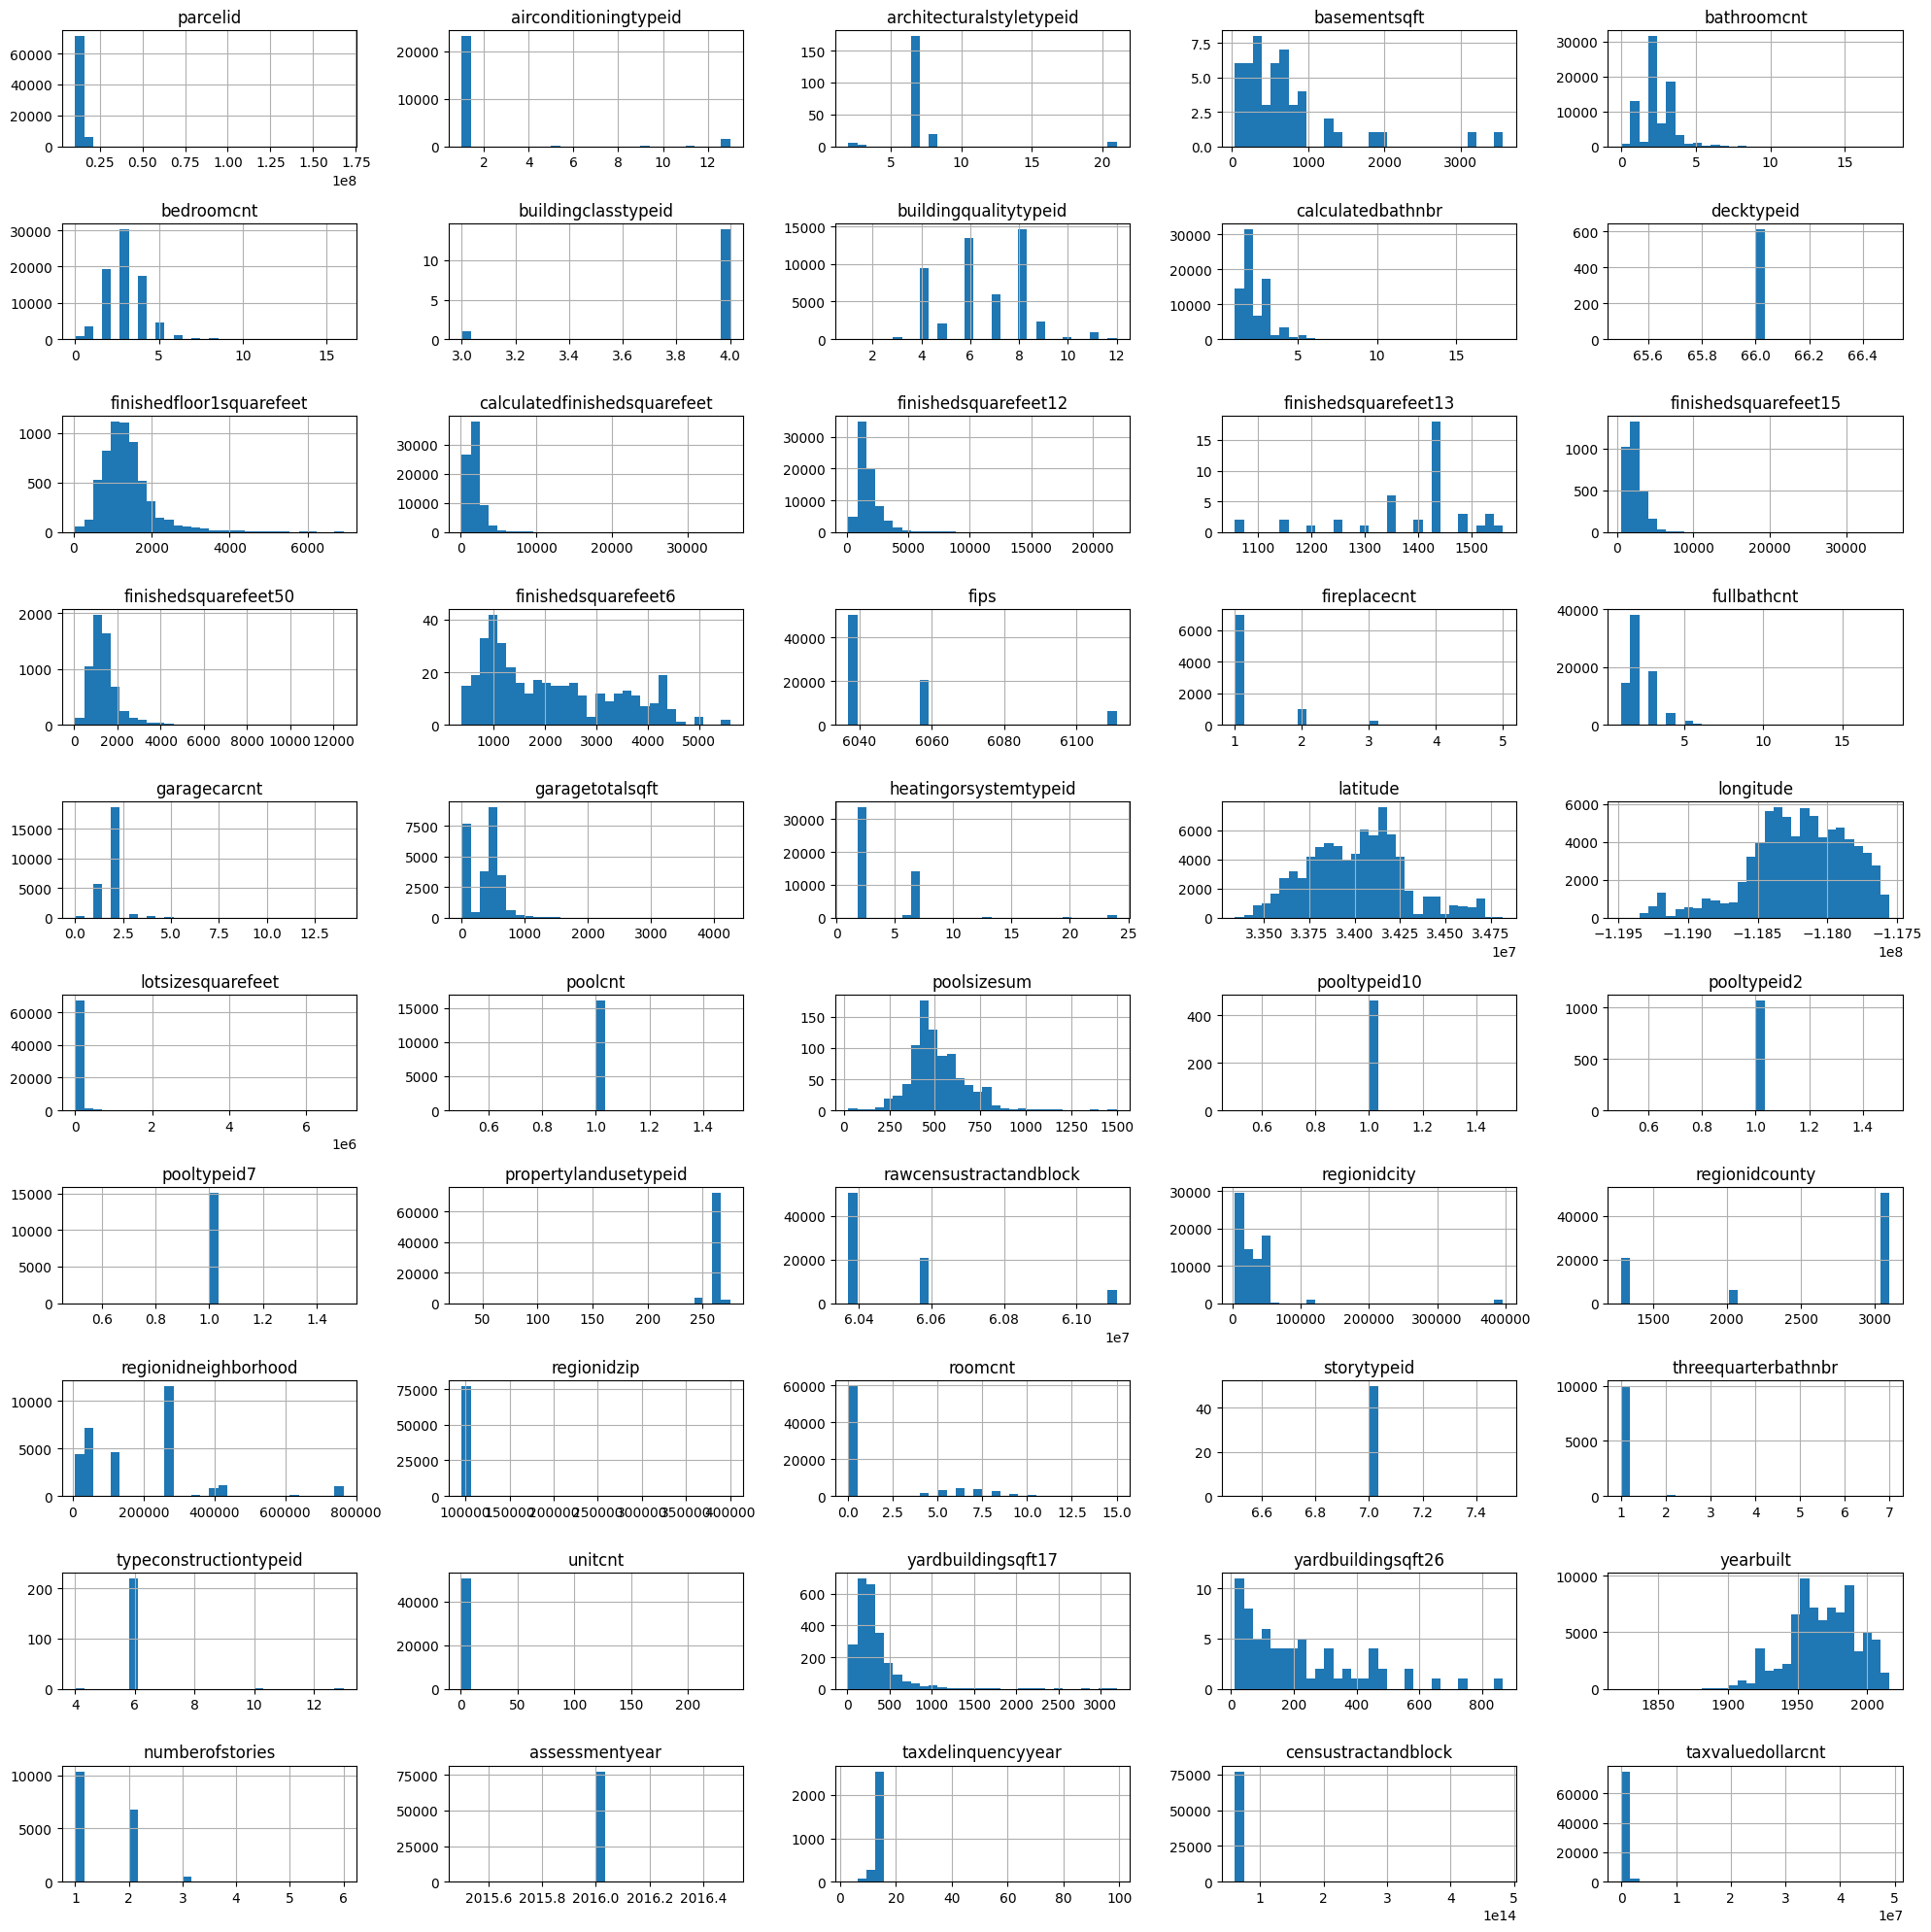

In [ ]:
# Generate histograms for all features in the dataframe
df.hist(figsize=(20,20),layout=(-1, 5), bins=30)
plt.tight_layout()  # Adjust layout to prevent truncation
plt.show()

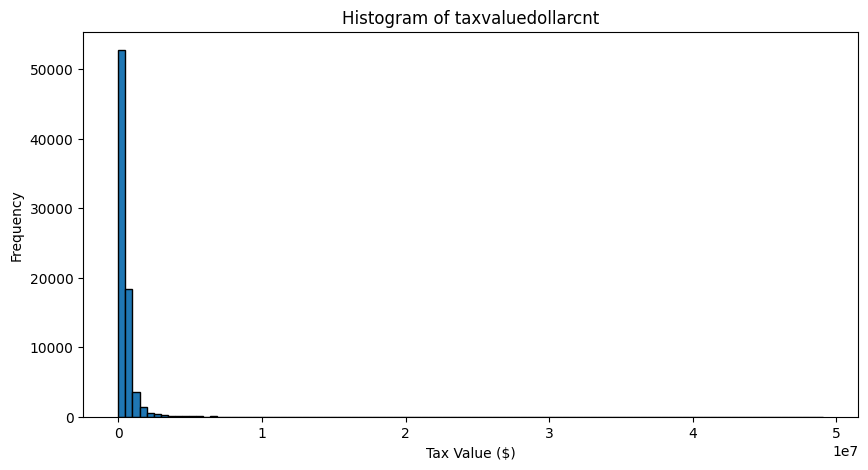

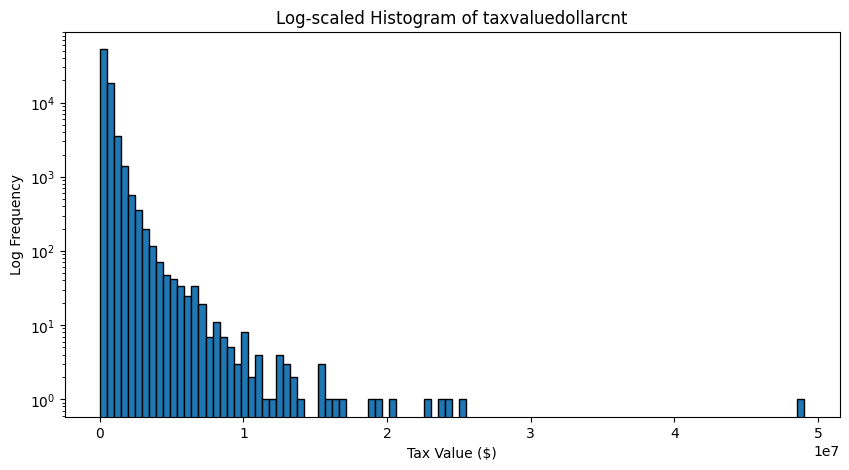

Mean: $490,150.59
Median: $358,878.50
Max: $49,061,236.00
Min: $1,000.00


In [ ]:
# Plot the target variable - 'taxvaluedollarcnt'
plt.figure(figsize=(10,5))
plt.hist(df['taxvaluedollarcnt'], bins=100, edgecolor='black')
plt.title("Histogram of taxvaluedollarcnt")
plt.xlabel("Tax Value ($)")
plt.ylabel("Frequency")
plt.show()

#log-scale
plt.figure(figsize=(10,5))
plt.hist(df['taxvaluedollarcnt'], bins=100, edgecolor='black')
plt.title("Log-scaled Histogram of taxvaluedollarcnt")
plt.yscale('log')
plt.xlabel("Tax Value ($)")
plt.ylabel("Log Frequency")
plt.show()

print(f"Mean: ${df['taxvaluedollarcnt'].mean():,.2f}")
print(f"Median: ${df['taxvaluedollarcnt'].median():,.2f}")
print(f"Max: ${df['taxvaluedollarcnt'].max():,.2f}")
print(f"Min: ${df['taxvaluedollarcnt'].min():,.2f}")

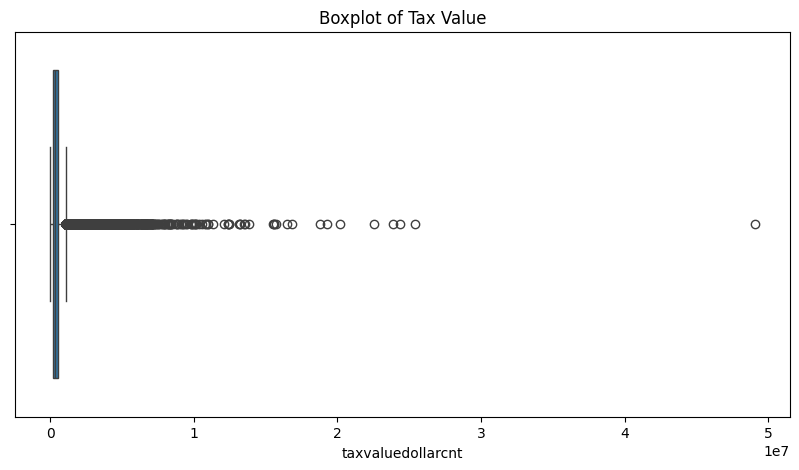

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['taxvaluedollarcnt'])
plt.title("Boxplot of Tax Value")
plt.show()

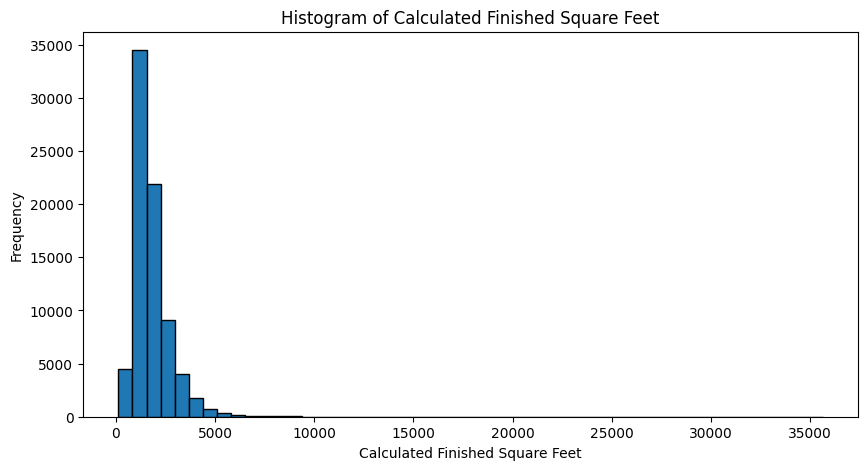

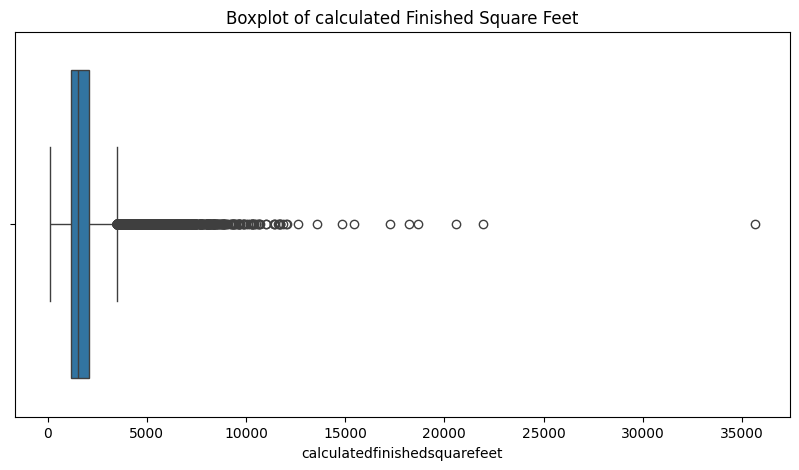

Mean: $1,784.94
Median: $1,542.00
Max: $35,640.00
Min: $128.00


In [ ]:
# calculatedfinishedsquarefeet Analysis

plt.figure(figsize=(10, 5))
plt.hist(df['calculatedfinishedsquarefeet'], bins=50, edgecolor="black")
plt.title("Histogram of Calculated Finished Square Feet")
plt.xlabel("Calculated Finished Square Feet")
plt.ylabel("Frequency")
plt.show()

# Boxplot for calculatedfinishedsquarefeet
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['calculatedfinishedsquarefeet'])
plt.title("Boxplot of calculated Finished Square Feet")
plt.show()

print(f"Mean: ${df['calculatedfinishedsquarefeet'].mean():,.2f}")
print(f"Median: ${df['calculatedfinishedsquarefeet'].median():,.2f}")
print(f"Max: ${df['calculatedfinishedsquarefeet'].max():,.2f}")
print(f"Min: ${df['calculatedfinishedsquarefeet'].min():,.2f}")

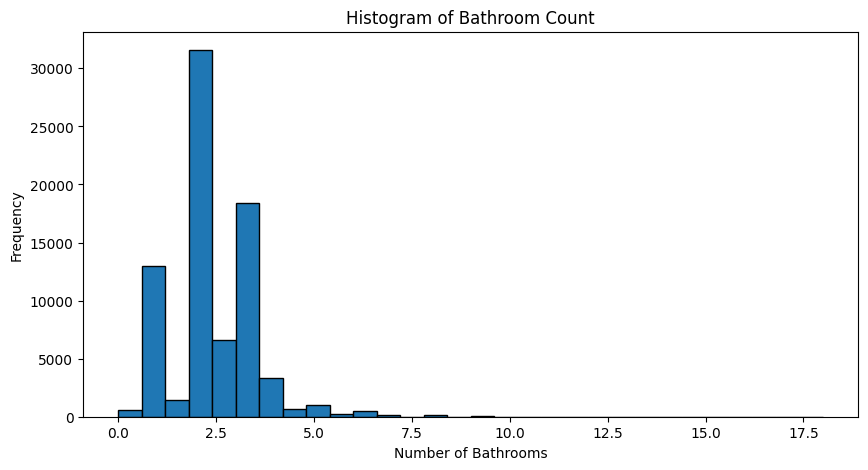

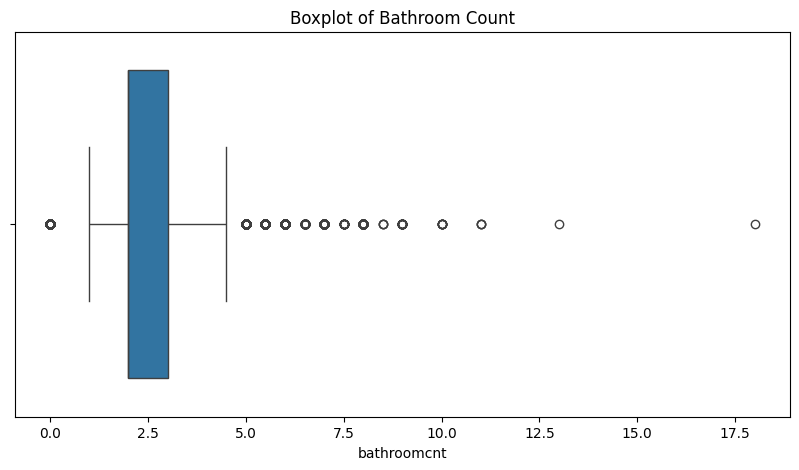

Mean: $2.30
Median: $2.00
Max: $18.00
Min: $0.00


In [ ]:
# Histogram of bathroomcnt
plt.figure(figsize=(10, 5))
plt.hist(df['bathroomcnt'], bins=30, edgecolor="black")
plt.title("Histogram of Bathroom Count")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Frequency")
plt.show()

# Boxplot for bathroomcnt
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['bathroomcnt'])
plt.title("Boxplot of Bathroom Count")
plt.show()

print(f"Mean: ${df['bathroomcnt'].mean():,.2f}")
print(f"Median: ${df['bathroomcnt'].median():,.2f}")
print(f"Max: ${df['bathroomcnt'].max():,.2f}")
print(f"Min: ${df['bathroomcnt'].min():,.2f}")

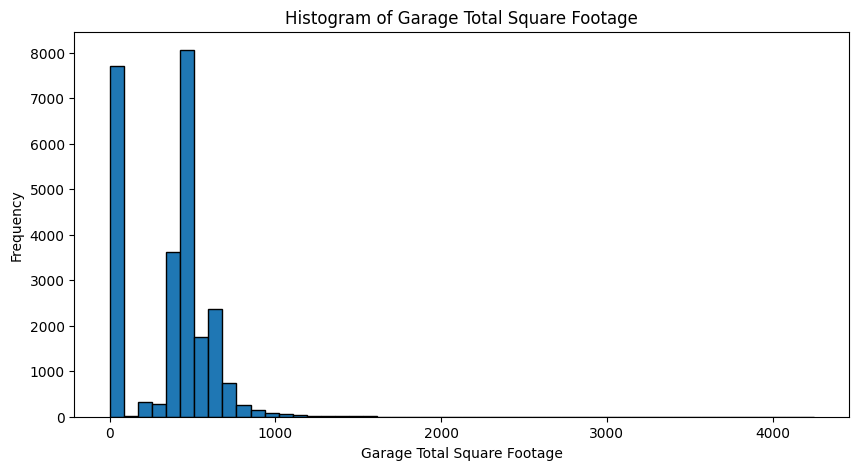

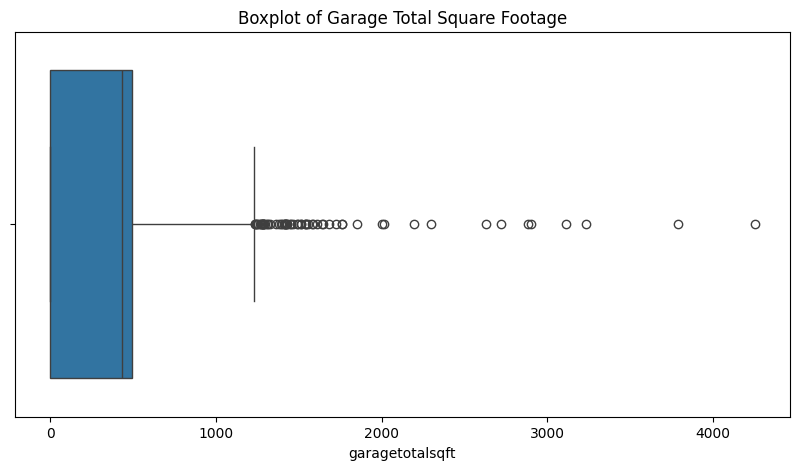

Mean: $350.05
Median: $436.00
Max: $4,251.00
Min: $0.00


In [ ]:
# Histogram for 'garagetotalsqft'
plt.figure(figsize=(10, 5))
plt.hist(df['garagetotalsqft'], bins=50, edgecolor="black")
plt.title("Histogram of Garage Total Square Footage")
plt.xlabel("Garage Total Square Footage")
plt.ylabel("Frequency")
plt.show()

# Boxplot for 'garagetotalsqft'
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['garagetotalsqft'])
plt.title("Boxplot of Garage Total Square Footage")
plt.show()


print(f"Mean: ${df['garagetotalsqft'].mean():,.2f}")
print(f"Median: ${df['garagetotalsqft'].median():,.2f}")
print(f"Max: ${df['garagetotalsqft'].max():,.2f}")
print(f"Min: ${df['garagetotalsqft'].min():,.2f}")

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


**Taxvaluedollarcnt** The histogram for taxvaluedollarcnt appears to follow a right-skewed distribution. The log-scaled histogram highlights the skewness and shows the concentration of values near the lower end of the scale.

Outliers: The boxplot clearly identifies several extreme outliers in the taxvaluedollarcnt data. These outliers represent properties with extraordinarily high tax values. These values need to be appropriately addressed.

**calculatedfinishedsquarefeet** The data for calculatedfinishedsquarefeet appears right-skewed with most values concentrated below 5,000 square feet. A small number of properties have exceptionally high square footage, reaching up to 35,640.00 square feet, which contributes to the long tail. The boxplot highlights numerous outliers on the higher end of the square footage range.

**bathroomcnt** The histogram shows a right-skewed distribution (positively skewed). Most of the data points are concentrated around lower values (between 1 and 5 bathrooms). The distribution is not a normal distribution. It appears to have a long right tail, indicating that a few properties have a very high number of bathrooms. The boxplot shows several outliers beyond the upper whisker. These correspond to properties with a high number of bathrooms. One extreme value go up to 18 bathrooms, which is quite unusual and may indicate data entry errors or luxury property.

**garagetotalsqft** The histogram shows a right-skewed distribution (positively skewed), with most properties having a garage total square footage below 1000 sqft. There is a long right tail, indicating that a few properties have exceptionally large garages (2000+ sqft). This distribution is not normal. The boxplot shows a large number of outliers beyond the upper whisker. One garage have an extreme square footage of 4,251 sqft, which is rare and may indicate either large commercial properties or potential data entry errors.

These features were chosen because they are key indicators of property size, value, and amenities, all of which significantly impact tax value analysis. However, the presence of extreme outliers across all examined features suggests the need for data cleaning, to improve model performance and reliability.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts] (Peter)



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task!

In [ ]:
#make a copy of the DataFrame
df_clean = df.copy()

#drop the columns with only 1 unique value identified by Nowrin
df_clean = df_clean.drop(columns=single_value_features).copy() #drop the columns with only 1 unique value identified by Nowrin

#drop unique identifier
df_clean = df_clean.drop(columns=['parcelid']) #drop unique identifier

# drop redundant columns (we'll get the rest when we drop features with too many nulls)
other_drops = ['propertycountylandusecode', #sparse/categorical
               'propertylandusetypeid', #sparse/categorical
               'propertyzoningdesc', #string
               'rawcensustractandblock', #possibly redundant with lat/long
               'regionidneighborhood', #redundant with other location data
               'censustractandblock', #possibly redundant with lat/long
               'calculatedbathnbr' # we've got beds and bathrooms and this will cause a problem with the imputred
               ]
df_clean = df_clean.drop(columns=other_drops)

In [ ]:
df_clean.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,...,roomcnt,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,taxdelinquencyyear,taxvaluedollarcnt
0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,NaN,3100.0,3100.0,...,0.0,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,1023282.0
1,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1465.0,1465.0,1465.0,...,5.0,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,464000.0
2,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,1243.0,1243.0,...,6.0,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,564778.0
3,NaN,NaN,NaN,3.0,4.0,NaN,8.0,NaN,2376.0,2376.0,...,0.0,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,145143.0
4,1.0,NaN,NaN,3.0,3.0,NaN,8.0,NaN,1312.0,1312.0,...,0.0,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,119407.0


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop.

In our feature selection process, we removed columns that did not offer significant variability or predictive value to the model.

- `parcelid` was removed, which functions solely as a unique identifier without inherent predictive capacity
- For instance, we dropped `decktypeid`, `hashottuborspa`, `poolcnt`, `pooltypeid10`, `pooltypeid2`, `pooltypeid7`, `storytypeid`, `fireplaceflag`, `assessmentyear`, and `taxdelinquencyflag` because these fields contained only a single unique value, rendering them uninformative.

- Additionally, to reduce sparsity and potential redundancy, we dropped `propertylandusecode` and `propertylandusetypeid` due to their sparse and categorical nature, as well as `propertyzoningdesc` because it is a string field that adds little consistent signal.
- Location-specific features, such as `rawcensustractandblock`, `regionidneighborhood`, `latitude` and `longitude`
- Finally, a number of features were removed to reduce the chance of multicollinearity, such as `fullbathcount` and `finishedsquarefeet12`.

This careful curation of features helps streamline our dataset, ensuring that our model focuses on variables that contribute meaningful insights into predicting real estate tax revenue.


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully.

In [ ]:
# helper functions
def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)

    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values,
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)

    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:.2f}%   {row['Type']}")

In [ ]:
show_null_counts_features(df_clean)

The dataset contains 77613 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
buildingclasstypeid 77598        99.98%   Numeric
finishedsquarefeet13 77571        99.95%   Numeric
basementsqft    77563        99.94%   Numeric
yardbuildingsqft26 77543        99.91%   Numeric
architecturalstyletypeid 77406        99.73%   Numeric
typeconstructiontypeid 77390        99.71%   Numeric
finishedsquarefeet6 77227        99.50%   Numeric
poolsizesum     76744        98.88%   Numeric
yardbuildingsqft17 75220        96.92%   Numeric
taxdelinquencyyear 74713        96.26%   Numeric
finishedsquarefeet15 74586        96.10%   Numeric
finishedfloor1squarefeet 71576        92.22%   Numeric
finishedsquarefeet50 71576        92.22%   Numeric
fireplacecnt    69324        89.32%   Numeric
threequarterbathnbr 67507        86.98%   Numeric
numberofstories 60014        77.32%   Numeric
airconditioningtypeid 52606        67.78%   Numeric
garagecarcnt    52093     

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         25007 non-null  float64
 1   architecturalstyletypeid      207 non-null    float64
 2   basementsqft                  50 non-null     float64
 3   bathroomcnt                   77579 non-null  float64
 4   bedroomcnt                    77579 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   buildingqualitytypeid         49809 non-null  float64
 7   finishedfloor1squarefeet      6037 non-null   float64
 8   calculatedfinishedsquarefeet  77378 non-null  float64
 9   finishedsquarefeet12          73923 non-null  float64
 10  finishedsquarefeet13          42 non-null     float64
 11  finishedsquarefeet15          3027 non-null   float64
 12  finishedsquarefeet50          6037 non-null   float64
 13  f

In [ ]:
df_clean.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,...,roomcnt,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,taxdelinquencyyear,taxvaluedollarcnt
0,NaN,NaN,NaN,3.5,4.0,NaN,NaN,NaN,3100.0,3100.0,...,0.0,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,1023282.0
1,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1465.0,1465.0,1465.0,...,5.0,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,464000.0
2,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,1243.0,1243.0,...,6.0,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,564778.0
3,NaN,NaN,NaN,3.0,4.0,NaN,8.0,NaN,2376.0,2376.0,...,0.0,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,145143.0
4,1.0,NaN,NaN,3.0,3.0,NaN,8.0,NaN,1312.0,1312.0,...,0.0,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,119407.0


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



In [ ]:
max_nulls = 69324 #basically the 90% null cutoff

# Count null values per column
cnt_nulls = df_clean.isnull().sum()
cnt_nulls


# Filter out columns where null count exceeds max_nulls
null_high = df_clean.columns[df_clean.isnull().sum() > max_nulls]

# Drop the columns
df_clean = df_clean.drop(columns=null_high)
print(len(null_high), "columns were removed.")
# Uncomment to verify they were removed
show_null_counts_features(df_clean)

13 columns were removed.
The dataset contains 77613 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
fireplacecnt    69324        89.32%   Numeric
threequarterbathnbr 67507        86.98%   Numeric
numberofstories 60014        77.32%   Numeric
airconditioningtypeid 52606        67.78%   Numeric
garagetotalsqft 52093        67.12%   Numeric
garagecarcnt    52093        67.12%   Numeric
heatingorsystemtypeid 28042        36.13%   Numeric
buildingqualitytypeid 27804        35.82%   Numeric
unitcnt         26910        34.67%   Numeric
lotsizesquarefeet 8292         10.68%   Numeric
finishedsquarefeet12 3690         4.75%   Numeric
regionidcity    1506         1.94%   Numeric
fullbathcnt     650          0.84%   Numeric
yearbuilt       304          0.39%   Numeric
calculatedfinishedsquarefeet 235          0.30%   Numeric
regionidzip     84           0.11%   Numeric
taxvaluedollarcnt 35           0.05%   Numeric
fips            34           0.

In [ ]:
# removing additional columns based on 3/29 discussion
additional_drops = ['fullbathcnt', 'finishedsquarefeet12', 'regionidcity', 'regionidcounty', 'latitude', 'longitude']
df_clean = df_clean.drop(columns=additional_drops)

 ### Feature selection process:
 - We first removed columns with little to no variability (such as those with only one unique value) and unique identifiers like parcelid.
 - We then applied a 50% missing value threshold to our dataset of 77,613 samples, resulting in the removal of 19 columns that did not have enough data to reliably contribute to our predictive model.
 - This threshold was chosen to ensure that the features retained have sufficient data for robust analysis.
 - The remaining dataset now includes 19 columns (e.g., heatingorsystemtypeid, buildingqualitytypeid, lotsizesquarefeet, finishedsquarefeet12, regionidcity, fullbathcnt, calculatedbathnbr, yearbuilt, taxvaluedollarcnt, etc.) that each have less than 50% null values.
 - However, it is worth noting that this approach has also excluded features that capture potentially useful property details, such as garage and pool information, due to their high sparsity. In future iterations, we might explore imputation strategies or alternative feature engineering methods to salvage such informative features without compromising data quality.
 - Based on this assessment, for now I've gone with a 90% null threshold to try to preserve features that could be dealt with via imputation

### Part 3.C: Drop Problematic **samples**

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [ ]:
df_clean = df_clean.dropna(subset=['taxvaluedollarcnt']) #drop rows with missing target

In [ ]:
def row_missingness_summary(df: pd.DataFrame) -> pd.DataFrame:
    # Count how many columns are missing in each row
    missing_counts = df.isnull().sum(axis=1)
    # Calculate the fraction of columns that are missing in each row
    total_cols = df.shape[1]
    missing_ratios = missing_counts / total_cols

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'missing_count': missing_counts,
        'missing_ratio': missing_ratios
    })
    summary_df.sort_values(by='missing_ratio', ascending=False, inplace=True)

    return summary_df

In [ ]:
df_clean_missing_assessment = row_missingness_summary(df_clean)
df_clean_missing_assessment.value_counts()

,,count
missing_count,missing_ratio,
6,0.333333,34753
5,0.277778,28334
7,0.388889,7038
4,0.222222,3104
8,0.444444,3066
3,0.166667,550
10,0.555556,323
9,0.500000,143
11,0.611111,103


In [ ]:
def drop_rows_with_missingness(df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    # Compute the fraction of missing values for each row
    row_missing_ratios = df.isnull().mean(axis=1)
    # Keep only rows with missing ratio <= threshold
    df_filtered = df[row_missing_ratios <= threshold].copy()

    return df_filtered

In [ ]:
df_clean = drop_rows_with_missingness(df_clean, threshold=0.5) #drop rows where more than 50% of the columns were missing values

In [ ]:
df_clean

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,lotsizesquarefeet,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,taxvaluedollarcnt
0,NaN,3.5,4.0,NaN,3100.0,6059.0,NaN,2.0,633.0,NaN,4506.0,96978.0,0.0,1.0,NaN,1998.0,NaN,1023282.0
1,NaN,1.0,2.0,NaN,1465.0,6111.0,1.0,1.0,0.0,NaN,12647.0,97099.0,5.0,NaN,NaN,1967.0,1.0,464000.0
2,NaN,2.0,3.0,NaN,1243.0,6059.0,NaN,2.0,440.0,NaN,8432.0,97078.0,6.0,NaN,NaN,1962.0,1.0,564778.0
3,NaN,3.0,4.0,8.0,2376.0,6037.0,NaN,NaN,NaN,2.0,13038.0,96330.0,0.0,NaN,1.0,1970.0,NaN,145143.0
4,1.0,3.0,3.0,8.0,1312.0,6037.0,NaN,NaN,NaN,2.0,278581.0,96451.0,0.0,NaN,1.0,1964.0,NaN,119407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,1.0,3.0,3.0,8.0,1741.0,6037.0,NaN,NaN,NaN,2.0,59487.0,96415.0,0.0,NaN,1.0,1980.0,NaN,379000.0
77609,NaN,2.0,2.0,6.0,1286.0,6037.0,NaN,NaN,NaN,2.0,47405.0,96284.0,0.0,NaN,1.0,1940.0,NaN,354621.0
77610,NaN,2.0,4.0,NaN,1612.0,6111.0,1.0,2.0,560.0,NaN,12105.0,97116.0,7.0,NaN,NaN,1964.0,1.0,67205.0
77611,1.0,1.0,3.0,4.0,1032.0,6037.0,NaN,NaN,NaN,2.0,5074.0,96480.0,0.0,NaN,1.0,1954.0,NaN,49546.0


In [ ]:
def remove_outliers_iqr(df: pd.DataFrame, column: str, multiplier: float = 1.5) -> tuple:
    # Calculate Q1 and Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Filter out outliers
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()

    return df_cleaned, lower_bound, upper_bound

cleaned_df, lb, ub = remove_outliers_iqr(df, 'taxvaluedollarcnt', multiplier=1.5)
print(f"Outlier bounds for taxvaluedollarcnt: lower={lb}, upper={ub}")
print(f"Rows before removal: {df.shape[0]}, after removal: {cleaned_df.shape[0]}")

Outlier bounds for taxvaluedollarcnt: lower=-336253.75, upper=1112152.25
Rows before removal: 77613, after removal: 72392


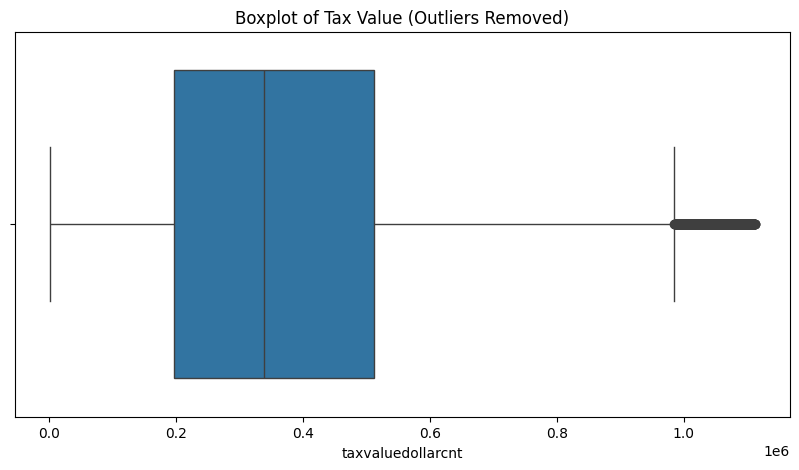

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.boxplot(x=cleaned_df['taxvaluedollarcnt'])
plt.title("Boxplot of Tax Value (Outliers Removed)")
plt.show()

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped

**Removing Missing Target Values:**
- We began by dropping any rows where the target variable (taxvaluedollarcnt) was missing. This ensures that our model only trains on samples with complete outcome data.

**Filtering Based on Row-Level Missingness:**
- Next, we eliminated rows that had more than 50% of their columns missing. This step was crucial for maintaining a high-quality dataset, as rows with excessive missing data can introduce noise and reduce model performance.

**Outlier Removal with the IQR Method:**
- Finally, we addressed potential outliers in the target variable. By calculating the interquartile range (IQR) and removing rows with target values exceeding the upper bound (typically defined as Q3 + 1.5×IQR), we reduced the influence of extreme values that might skew our regression results.

Together, these steps help streamline our dataset, ensuring that we maintain a robust sample of data for reliable predictions while mitigating issues caused by missing values and extreme outliers.


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [ ]:
df_clean.head()

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,lotsizesquarefeet,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,taxvaluedollarcnt
0,NaN,3.5,4.0,NaN,3100.0,6059.0,NaN,2.0,633.0,NaN,4506.0,96978.0,0.0,1.0,NaN,1998.0,NaN,1023282.0
1,NaN,1.0,2.0,NaN,1465.0,6111.0,1.0,1.0,0.0,NaN,12647.0,97099.0,5.0,NaN,NaN,1967.0,1.0,464000.0
2,NaN,2.0,3.0,NaN,1243.0,6059.0,NaN,2.0,440.0,NaN,8432.0,97078.0,6.0,NaN,NaN,1962.0,1.0,564778.0
3,NaN,3.0,4.0,8.0,2376.0,6037.0,NaN,NaN,NaN,2.0,13038.0,96330.0,0.0,NaN,1.0,1970.0,NaN,145143.0
4,1.0,3.0,3.0,8.0,1312.0,6037.0,NaN,NaN,NaN,2.0,278581.0,96451.0,0.0,NaN,1.0,1964.0,NaN,119407.0


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77069 entries, 0 to 77612
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         25007 non-null  float64
 1   bathroomcnt                   77069 non-null  float64
 2   bedroomcnt                    77069 non-null  float64
 3   buildingqualitytypeid         49807 non-null  float64
 4   calculatedfinishedsquarefeet  77064 non-null  float64
 5   fips                          77069 non-null  float64
 6   fireplacecnt                  8287 non-null   float64
 7   garagecarcnt                  25519 non-null  float64
 8   garagetotalsqft               25519 non-null  float64
 9   heatingorsystemtypeid         49571 non-null  float64
 10  lotsizesquarefeet             69204 non-null  float64
 11  regionidzip                   77026 non-null  float64
 12  roomcnt                       77069 non-null  float64
 13  threeq

In [ ]:
df_clean.describe()

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,lotsizesquarefeet,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,taxvaluedollarcnt
count,25007.000000,77069.000000,77069.000000,49807.000000,77064.000000,77069.000000,8287.000000,25519.000000,25519.000000,49571.000000,6.920400e+04,77026.000000,77069.000000,10106.000000,50699.000000,76993.000000,17598.000000,7.706900e+04
mean,1.812013,2.307406,3.066538,6.533821,1788.245199,6048.752559,1.191263,1.815314,350.050433,3.921749,2.990809e+04,96584.723314,1.485448,1.009598,1.110318,1968.515034,1.434311,4.894044e+05
std,2.965768,0.991562,1.129763,1.722057,954.576835,20.773748,0.491031,0.588329,261.650643,3.594780,1.230666e+05,3805.775196,2.830062,0.118572,1.170013,23.779454,0.544521,6.510122e+05
min,1.000000,0.000000,0.000000,1.000000,128.000000,6037.000000,1.000000,0.000000,0.000000,1.000000,2.360000e+02,95982.000000,0.000000,1.000000,1.000000,1824.000000,1.000000,1.000000e+03
25%,1.000000,2.000000,2.000000,6.000000,1186.000000,6037.000000,1.000000,2.000000,0.000000,2.000000,5.700000e+03,96193.000000,0.000000,1.000000,1.000000,1953.000000,1.000000,2.068630e+05
50%,1.000000,2.000000,3.000000,6.000000,1546.000000,6037.000000,1.000000,2.000000,436.000000,2.000000,7.205000e+03,96389.000000,0.000000,1.000000,1.000000,1970.000000,1.000000,3.589790e+05
75%,1.000000,3.000000,4.000000,8.000000,2115.000000,6059.000000,1.000000,2.000000,492.000000,7.000000,1.181900e+04,96985.000000,0.000000,1.000000,1.000000,1987.000000,2.000000,5.695420e+05
max,13.000000,18.000000,16.000000,12.000000,35640.000000,6111.000000,5.000000,14.000000,4251.000000,24.000000,6.971010e+06,399675.000000,15.000000,7.000000,237.000000,2016.000000,6.000000,4.906124e+07


In [ ]:
df_clean.columns

Index(['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'fips',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'lotsizesquarefeet', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'unitcnt', 'yearbuilt', 'numberofstories',
       'taxvaluedollarcnt'],
      dtype='object')

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#make a copy of only the features
df_imputed = df_clean.copy().drop(columns=['taxvaluedollarcnt']) #to avoid the target when imputing

#seprate categorical features vs numeric ones
categorical_features = ['airconditioningtypeid', 'buildingqualitytypeid', 'fips','heatingorsystemtypeid', 'regionidzip', 'unitcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']

numeric_features = numeric_features = [col for col in df_imputed.columns if col not in categorical_features]

#categorical pipeline
categorical_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent'))])

#numeric pipeline
numeric_pipeline = Pipeline(steps=[('imputer', IterativeImputer(random_state=42))])

#combine pipelines
preprocessor = ColumnTransformer(transformers=[('num', numeric_pipeline, numeric_features),('cat', categorical_pipeline, categorical_features)])

# fit the preprocessor to the data and transform it
df_preprocessed = preprocessor.fit_transform(df_imputed)

#convert back to a dataframe
processed_columns = numeric_features + categorical_features
df_preprocessed = pd.DataFrame(df_preprocessed, columns=processed_columns)

df_preprocessed.head()

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,bathroomcnt,bedroomcnt,fireplacecnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,threequarterbathnbr,numberofstories,airconditioningtypeid,buildingqualitytypeid,fips,heatingorsystemtypeid,regionidzip,unitcnt,calculatedfinishedsquarefeet,yearbuilt
0,3.5,4.0,1.441748,2.000000,633.000000,4506.0,0.0,1.000000,1.240230,1.0,8.0,6059.0,2.0,96978.0,1.0,3100.0,1998.0
1,1.0,2.0,1.000000,1.000000,0.000000,12647.0,5.0,0.967309,1.000000,1.0,8.0,6111.0,2.0,97099.0,1.0,1465.0,1967.0
2,2.0,3.0,1.046775,2.000000,440.000000,8432.0,6.0,1.062137,1.000000,1.0,8.0,6059.0,2.0,97078.0,1.0,1243.0,1962.0
3,3.0,4.0,1.158672,1.898036,457.631096,13038.0,0.0,1.020572,1.135574,1.0,8.0,6037.0,2.0,96330.0,1.0,2376.0,1970.0
4,3.0,3.0,1.242973,2.027981,-65.950119,278581.0,0.0,0.993066,1.609744,1.0,8.0,6037.0,2.0,96451.0,1.0,1312.0,1964.0


In [ ]:
#reorder back to the original order

original_features = [col for col in df_clean.columns if col != 'taxvaluedollarcnt']
# This step aligns the columns in the same order as in original_features
df_preprocessed = df_preprocessed.reindex(columns=original_features)
# df_preprocessed['taxvaluedollarcnt'] = df_clean['taxvaluedollarcnt'] # uncomment to add back in target
df_preprocessed.head()

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,lotsizesquarefeet,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories
0,1.0,3.5,4.0,8.0,3100.0,6059.0,1.441748,2.000000,633.000000,2.0,4506.0,96978.0,0.0,1.000000,1.0,1998.0,1.240230
1,1.0,1.0,2.0,8.0,1465.0,6111.0,1.000000,1.000000,0.000000,2.0,12647.0,97099.0,5.0,0.967309,1.0,1967.0,1.000000
2,1.0,2.0,3.0,8.0,1243.0,6059.0,1.046775,2.000000,440.000000,2.0,8432.0,97078.0,6.0,1.062137,1.0,1962.0,1.000000
3,1.0,3.0,4.0,8.0,2376.0,6037.0,1.158672,1.898036,457.631096,2.0,13038.0,96330.0,0.0,1.020572,1.0,1970.0,1.135574
4,1.0,3.0,3.0,8.0,1312.0,6037.0,1.242973,2.027981,-65.950119,2.0,278581.0,96451.0,0.0,0.993066,1.0,1964.0,1.609744


In [ ]:
# Example list of integer columns (update with your actual column names)
int_columns = ['bathroomcnt', 'bedroomcnt', 'fireplacecnt',
               'garagecarcnt', 'roomcnt', 'threequarterbathnbr', 'unitcnt',
               'numberofstories']

# Round and cast each column back to integer
for col in int_columns:
    df_preprocessed[col] = df_preprocessed[col].round().astype(int)

# Verify the changes
print(df_preprocessed[int_columns].dtypes)

bathroomcnt            int64
bedroomcnt             int64
fireplacecnt           int64
garagecarcnt           int64
roomcnt                int64
threequarterbathnbr    int64
unitcnt                int64
numberofstories        int64
dtype: object


In [ ]:
print(df_preprocessed.describe())

       airconditioningtypeid   bathroomcnt    bedroomcnt  \
count           77069.000000  77069.000000  77069.000000   
mean                1.263478      2.277180      3.066538   
std                 1.731608      0.993627      1.129763   
min                 1.000000      0.000000      0.000000   
25%                 1.000000      2.000000      2.000000   
50%                 1.000000      2.000000      3.000000   
75%                 1.000000      3.000000      4.000000   
max                13.000000     18.000000     16.000000   

       buildingqualitytypeid  calculatedfinishedsquarefeet          fips  \
count           77069.000000                  77069.000000  77069.000000   
mean                7.052459                   1788.207035   6048.752559   
std                 1.551745                    954.557628     20.773748   
min                 1.000000                    128.000000   6037.000000   
25%                 6.000000                   1186.000000   6037.000000   
50%

In [ ]:
print(df_clean.describe())

       airconditioningtypeid   bathroomcnt    bedroomcnt  \
count           25007.000000  77069.000000  77069.000000   
mean                1.812013      2.307406      3.066538   
std                 2.965768      0.991562      1.129763   
min                 1.000000      0.000000      0.000000   
25%                 1.000000      2.000000      2.000000   
50%                 1.000000      2.000000      3.000000   
75%                 1.000000      3.000000      4.000000   
max                13.000000     18.000000     16.000000   

       buildingqualitytypeid  calculatedfinishedsquarefeet          fips  \
count           49807.000000                  77064.000000  77069.000000   
mean                6.533821                   1788.245199   6048.752559   
std                 1.722057                    954.576835     20.773748   
min                 1.000000                    128.000000   6037.000000   
25%                 6.000000                   1186.000000   6037.000000   
50%

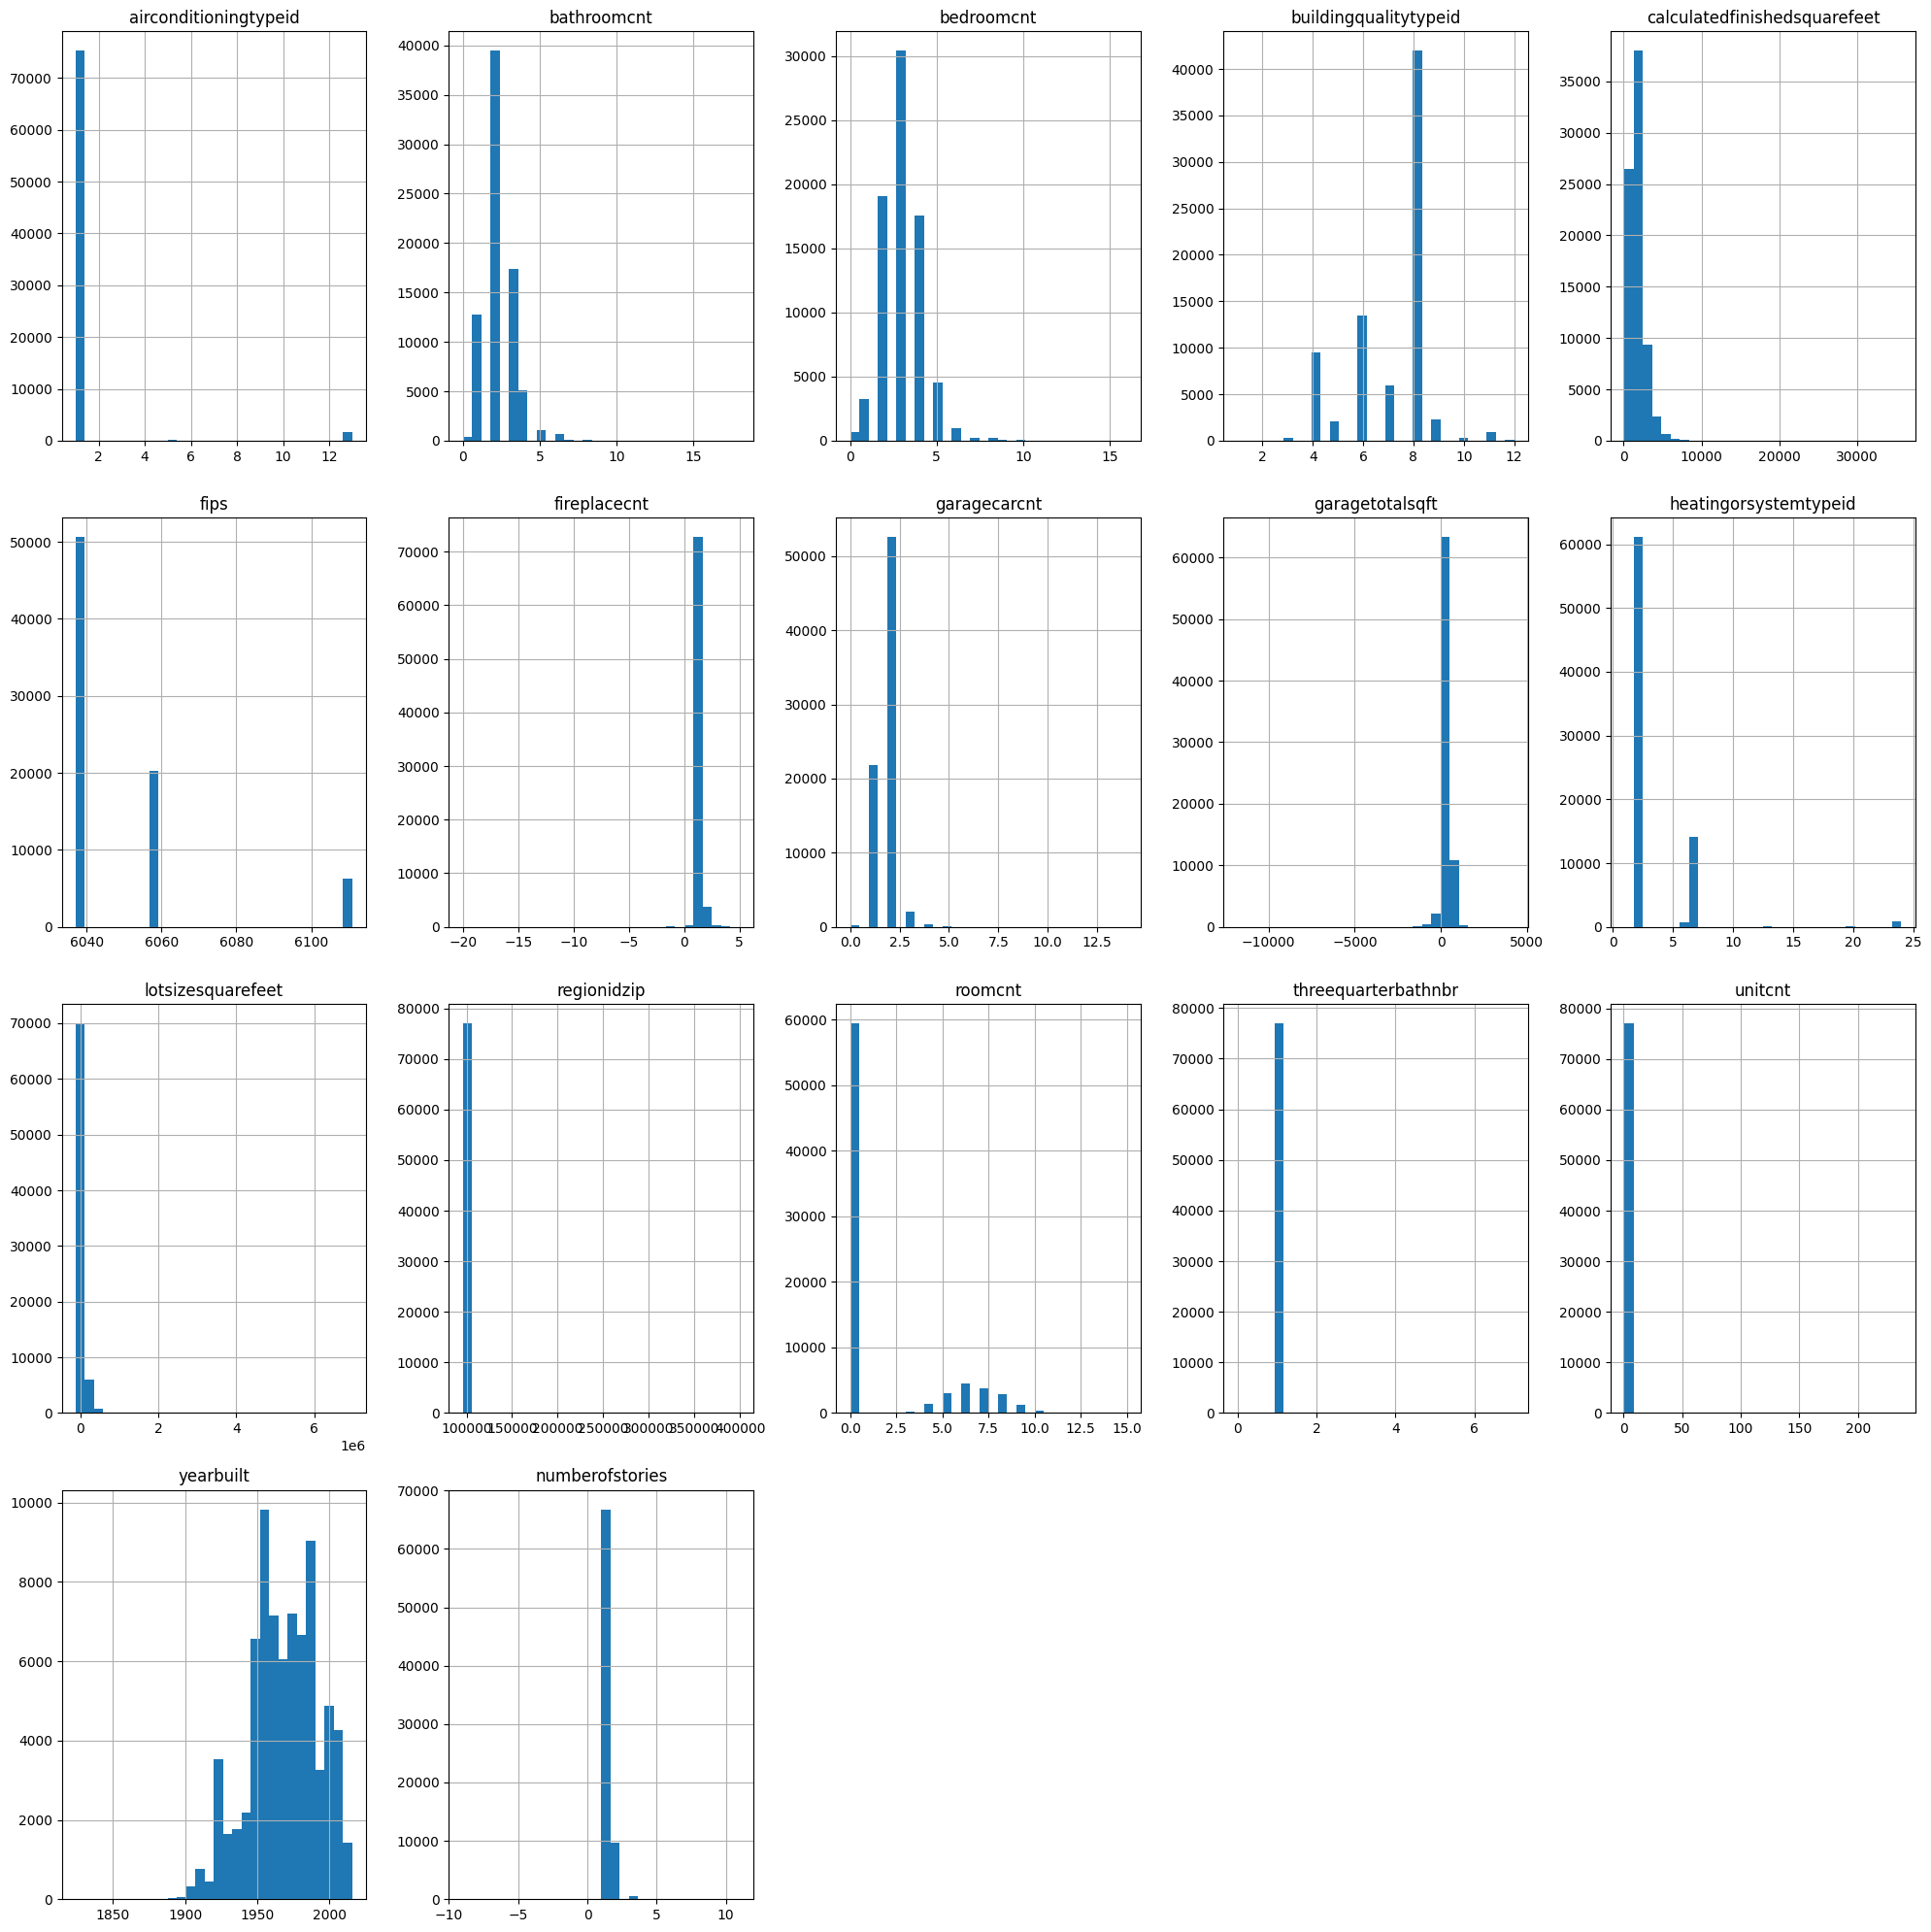

In [ ]:
df_preprocessed.hist(figsize=(20,20),layout=(-1, 5), bins=30)
plt.tight_layout()  # Adjust layout to prevent truncation
plt.show()

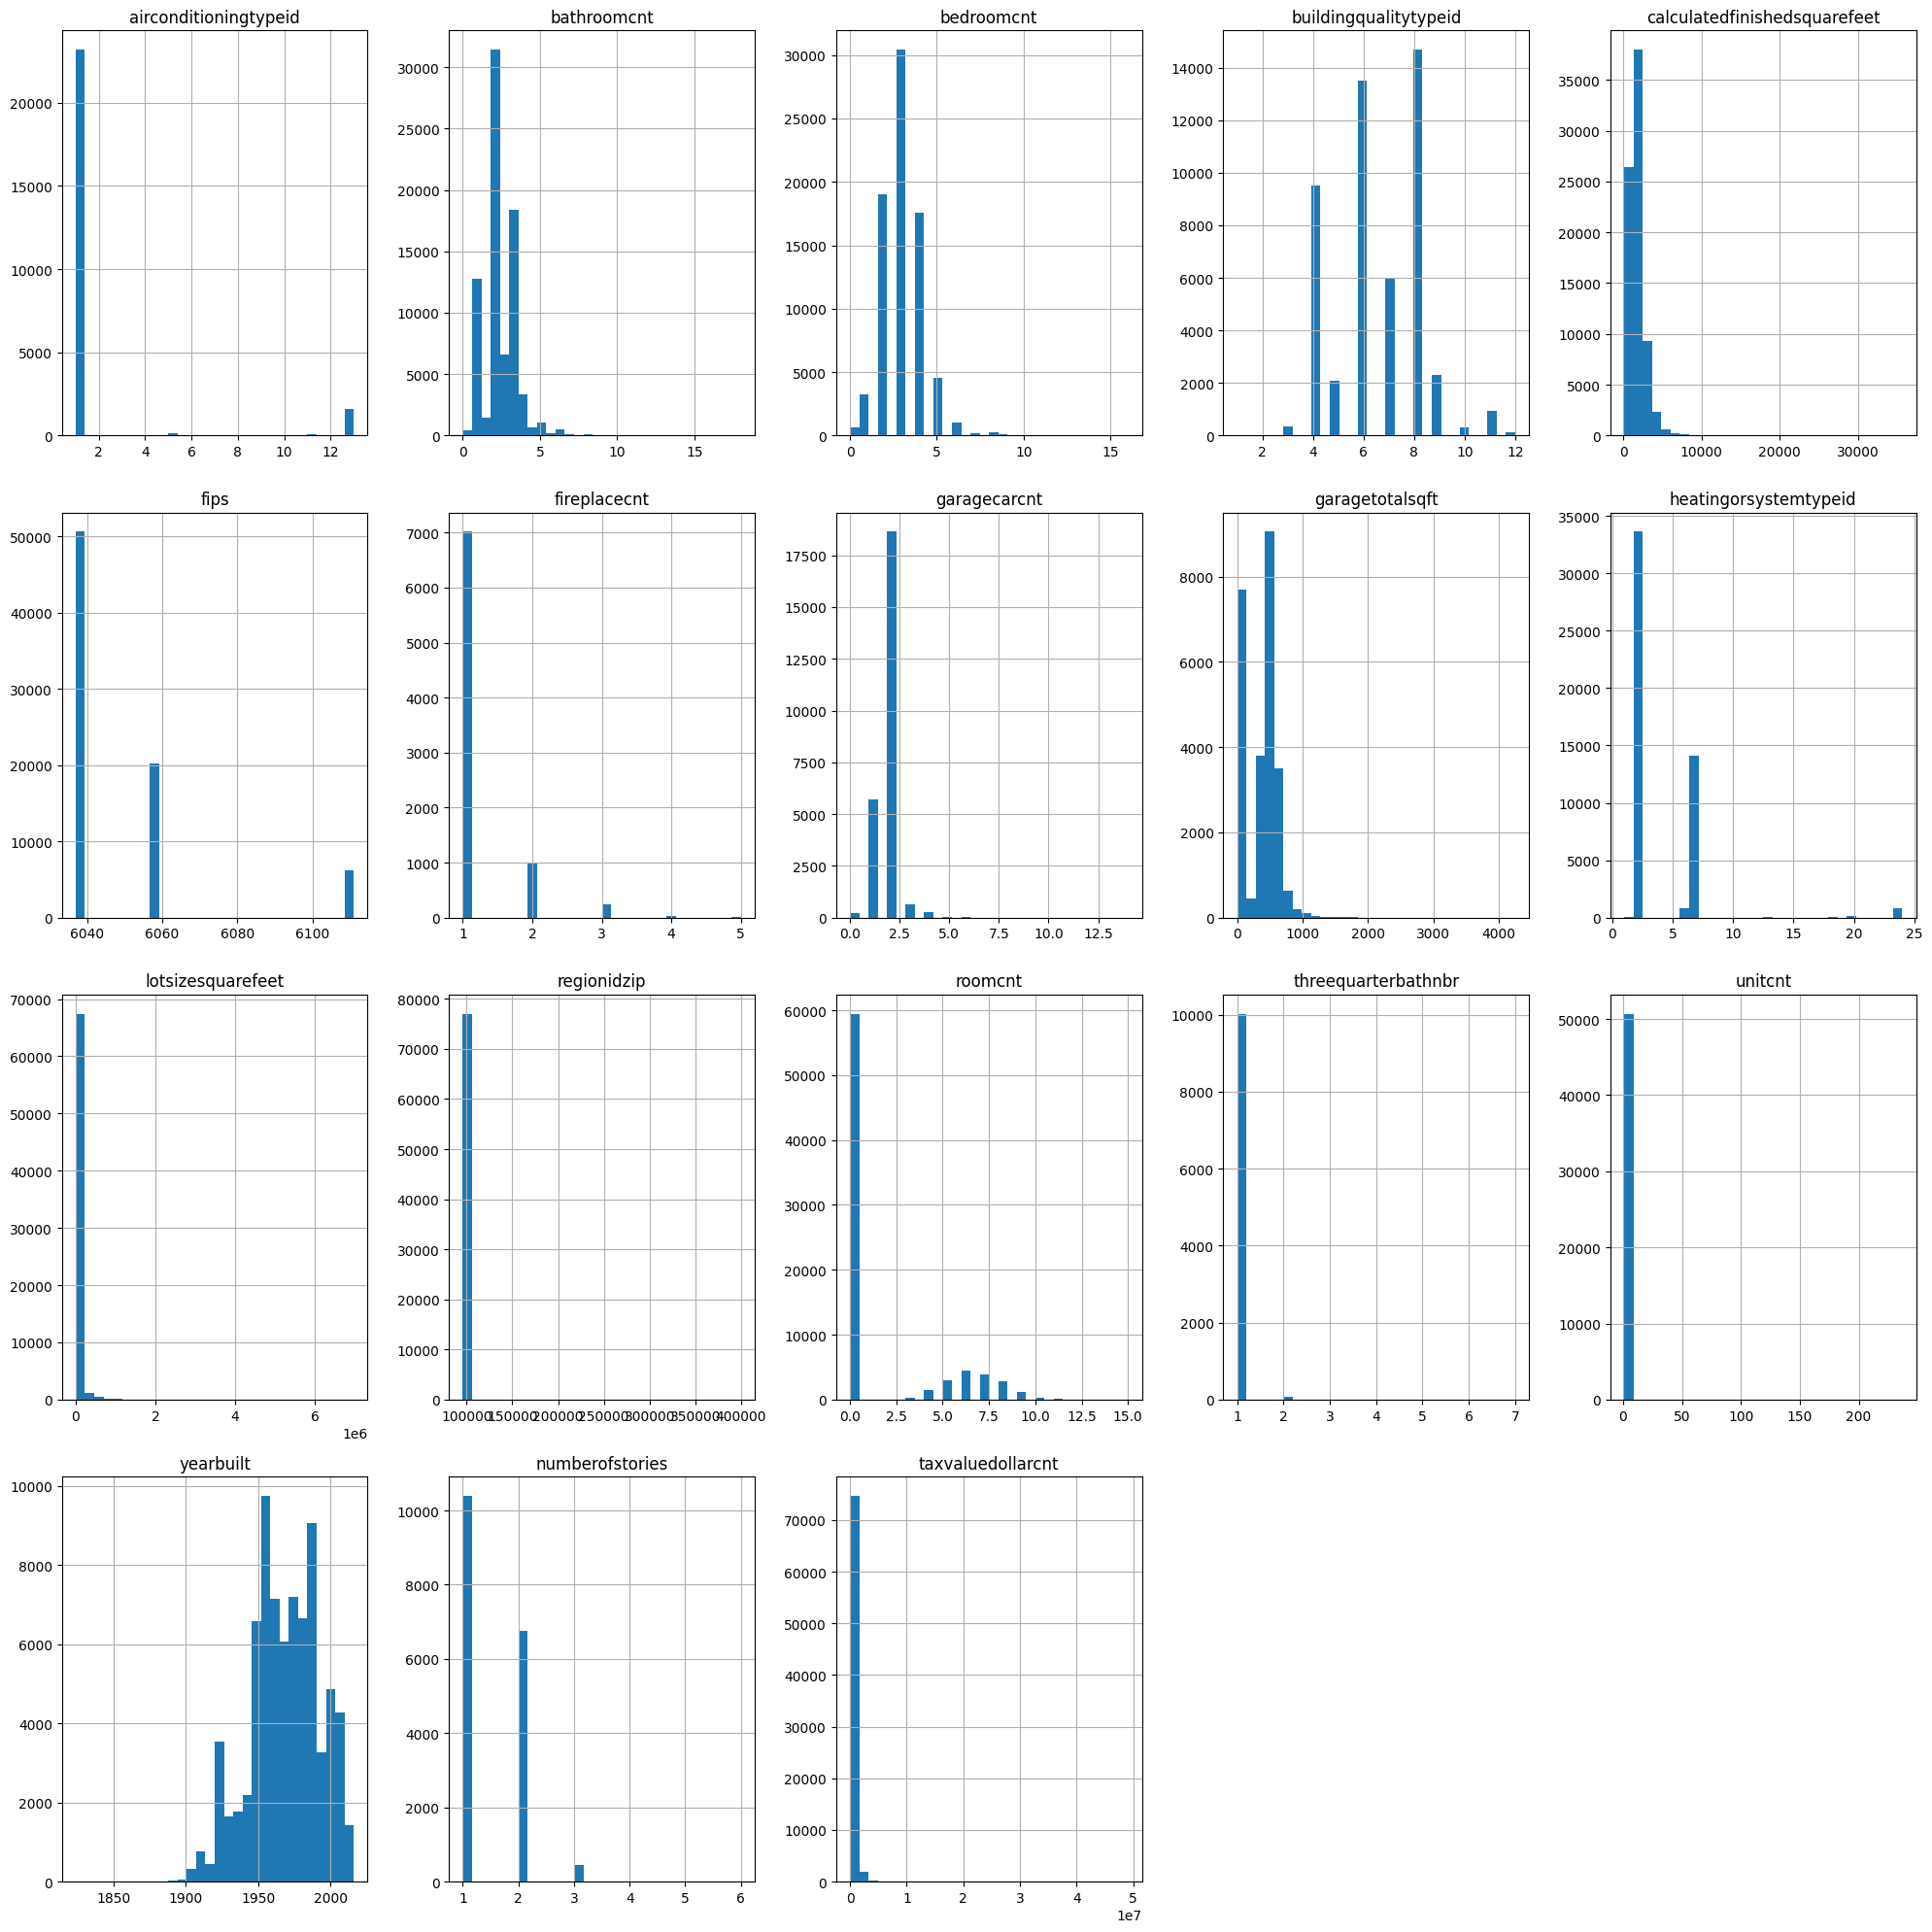

In [ ]:
df_clean.hist(figsize=(20,20),layout=(-1, 5), bins=30)
plt.tight_layout()  # Adjust layout to prevent truncation
plt.show()

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary.

In [ ]:
print(categorical_features)

['airconditioningtypeid', 'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'regionidzip', 'unitcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Define your categorical features
categorical_features = [
    'airconditioningtypeid', 'buildingqualitytypeid', 'fips',
    'heatingorsystemtypeid','regionidzip']

# Instantiate the OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform the categorical features
encoded_cats = encoder.fit_transform(df_preprocessed[categorical_features])

# Convert the encoded array back to a DataFrame
encoded_cat_df = pd.DataFrame(encoded_cats, columns=categorical_features, index=df_preprocessed.index)

# Identify the numeric features (everything that is not categorical)
numeric_features = [col for col in df_preprocessed.columns if col not in categorical_features]
df_numeric = df_preprocessed[numeric_features]

# Combine the numeric features with the encoded categorical features
df_encoded = pd.concat([df_numeric, encoded_cat_df], axis=1)

print(df_encoded.head())

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  fireplacecnt  \
0            4           4                        3100.0             1   
1            1           2                        1465.0             1   
2            2           3                        1243.0             1   
3            3           4                        2376.0             1   
4            3           3                        1312.0             1   

   garagecarcnt  garagetotalsqft  lotsizesquarefeet  roomcnt  \
0             2       633.000000             4506.0        0   
1             1         0.000000            12647.0        5   
2             2       440.000000             8432.0        6   
3             2       457.631096            13038.0        0   
4             2       -65.950119           278581.0        0   

   threequarterbathnbr  unitcnt  yearbuilt  numberofstories  \
0                    1        1     1998.0                1   
1                    1        1     1967.0  

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77069 entries, 0 to 77068
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   77069 non-null  int64  
 1   bedroomcnt                    77069 non-null  int64  
 2   calculatedfinishedsquarefeet  77069 non-null  float64
 3   fireplacecnt                  77069 non-null  int64  
 4   garagecarcnt                  77069 non-null  int64  
 5   garagetotalsqft               77069 non-null  float64
 6   lotsizesquarefeet             77069 non-null  float64
 7   roomcnt                       77069 non-null  int64  
 8   threequarterbathnbr           77069 non-null  int64  
 9   unitcnt                       77069 non-null  int64  
 10  yearbuilt                     77069 non-null  float64
 11  numberofstories               77069 non-null  int64  
 12  airconditioningtypeid         77069 non-null  float64
 13  b

## Part 4:  Investigate Feature Relationships  [6 pts] (Matt)

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project.

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments.

In [ ]:
# Correlation Matrix for Pairwise Correlation
df_relationships = df_encoded.copy() # Create copy for compartmentalization of this section
df_relationships['taxvaluedollarcnt'] = df_clean['taxvaluedollarcnt'] # Add in Target - Preprocessing pipeline produced Null values in Target when I uncommented and ran it through
df_corr = df_relationships.corr()

# Display Matrix
df_corr

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,garagecarcnt,garagetotalsqft,lotsizesquarefeet,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,airconditioningtypeid,buildingqualitytypeid,fips,heatingorsystemtypeid,regionidzip,taxvaluedollarcnt
bathroomcnt,1.000000,0.620556,0.763624,0.451413,0.641351,0.459721,-0.003372,0.014654,0.079304,0.054064,0.346926,0.172687,0.016456,0.386100,-0.010957,-0.262382,0.024688,0.000656
bedroomcnt,0.620556,1.000000,0.630064,0.287556,0.582763,0.562091,-0.136215,0.163324,0.031858,0.084747,0.053213,0.095886,0.049458,0.090320,0.039099,-0.152984,0.078771,-0.001960
calculatedfinishedsquarefeet,0.763624,0.630064,1.000000,0.461998,0.546132,0.495978,-0.072677,0.095462,0.089747,0.079518,0.220948,0.196610,0.057185,0.322924,0.070941,-0.217907,0.056362,-0.002895
fireplacecnt,0.451413,0.287556,0.461998,1.000000,0.331331,0.241137,0.040770,0.155309,-0.339654,-0.003412,0.129521,0.270844,0.051633,0.151286,0.120673,-0.067035,0.043896,-0.000047
garagecarcnt,0.641351,0.582763,0.546132,0.331331,1.000000,0.370020,0.146232,0.133324,0.032425,0.028292,0.257409,0.199182,0.066641,0.293405,0.078127,-0.247116,0.133172,-0.002625
garagetotalsqft,0.459721,0.562091,0.495978,0.241137,0.370020,1.000000,-0.787677,0.219587,0.129154,0.047262,-0.001969,-0.206875,0.102443,0.107808,0.091387,-0.122988,0.062931,0.001797
lotsizesquarefeet,-0.003372,-0.136215,-0.072677,0.040770,0.146232,-0.787677,1.000000,-0.074370,-0.120020,-0.020163,0.184904,0.421615,-0.037793,0.100968,0.005884,-0.036237,0.033614,-0.004433
roomcnt,0.014654,0.163324,0.095462,0.155309,0.133324,0.219587,-0.074370,1.000000,0.011079,-0.039255,0.077745,0.440018,0.303779,0.320512,0.758917,-0.052563,0.441076,-0.001518
threequarterbathnbr,0.079304,0.031858,0.089747,-0.339654,0.032425,0.129154,-0.120020,0.011079,1.000000,-0.001964,0.030699,-0.184948,0.006813,0.016835,0.025548,-0.008206,0.020853,0.000660
unitcnt,0.054064,0.084747,0.079518,-0.003412,0.028292,0.047262,-0.020163,-0.039255,-0.001964,1.000000,-0.076667,0.004224,-0.008486,-0.074754,-0.031269,-0.007929,-0.060757,0.002127


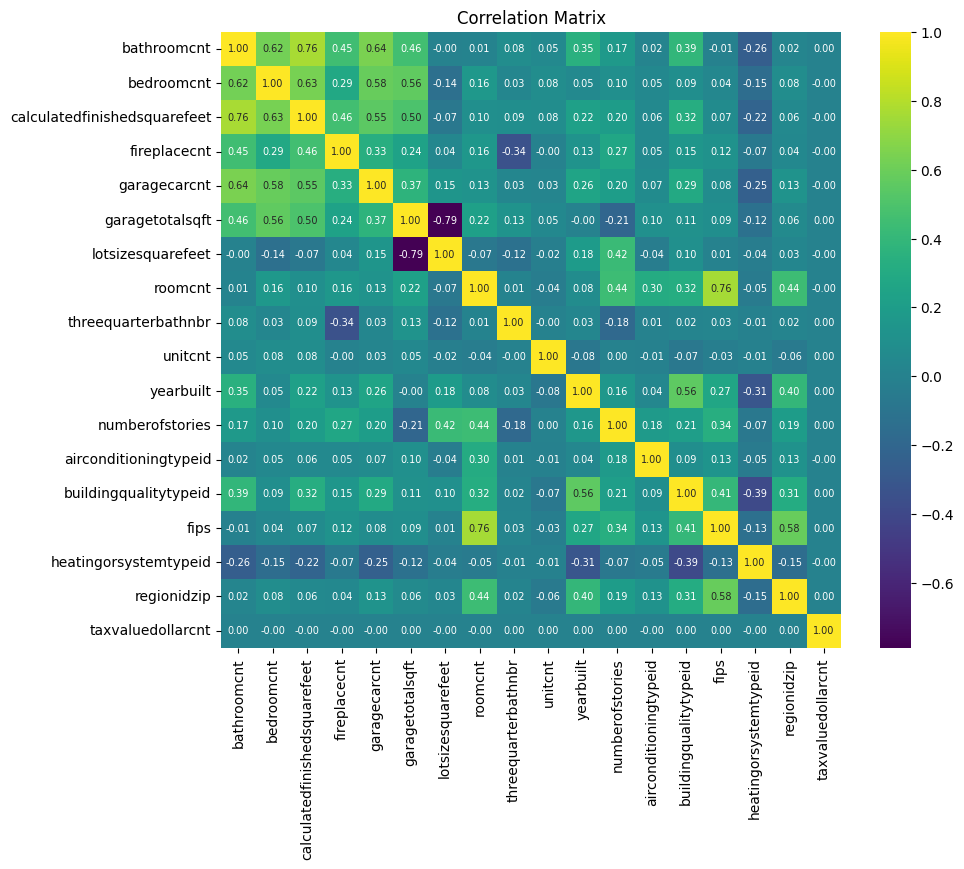

In [ ]:
# Plot the matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_corr, cmap='viridis', annot=True, fmt='.2f', annot_kws={'size': 7})
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Computing F Statistic
x = df_relationships.drop(columns=['taxvaluedollarcnt'], inplace=False)
y = df_clean['taxvaluedollarcnt']

f, p = f_regression(x, y)
f_statistics = pd.DataFrame({'feature': x.columns, 'f': f})
f_statistics

,feature,f
0,bathroomcnt,21773.684403
1,bedroomcnt,5071.444503
2,calculatedfinishedsquarefeet,39774.786002
3,fireplacecnt,9771.446492
4,garagecarcnt,6441.206713
5,garagetotalsqft,4974.691626
6,lotsizesquarefeet,47.618671
7,roomcnt,0.527362
8,threequarterbathnbr,347.724996
9,unitcnt,1.752973


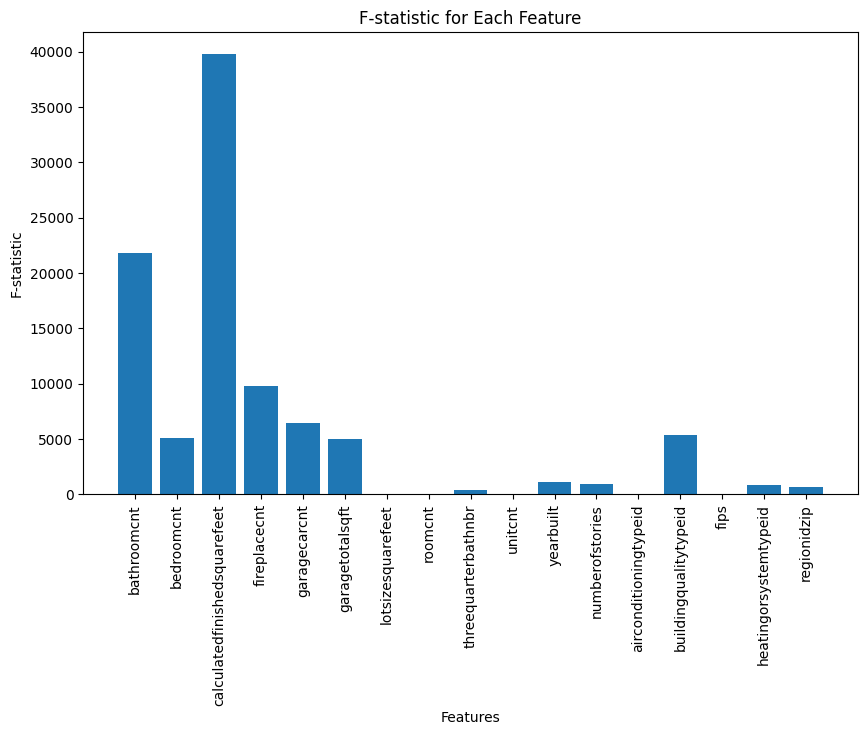

In [ ]:
# Ploting the F's
plt.figure(figsize=(10, 6))
plt.bar(f_statistics['feature'], f_statistics['f'])
plt.title('F-statistic for Each Feature')
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

**Notable Features**
- ***Finished Square feet:*** Finished Square feet encompasses both calculatedfinishedsquarefeet and finishedsquarefeet12, which have the two highest F-Statistics of all features. This means they account for the most variation in the target. This makes sense, since house size is a significant predictor of value, intuitively. They also are strongly correlated with eachother - which could harm their combined usefulness in a model.
- ***Bathroom Count:*** Similar to square footage, the bathroomcnt and fullbathroomcnt are some of the highest F-Statistics. They are also very strongly correlated with one another, leaving questions about their combined usefulness in a model.
- ***Garage Total Square Feet:*** On the other hand, garagetotalsqft is the third strongest F-Statistic, but isn't as strongly correlated to other features. It does have some moderate correlations with Finished Square Footage and Bathroom Count for example, which could just indicate that it predicts value well - evidenced by the high F-Stat.

In [ ]:
# Investigate forward and backward feature selection
# Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

# from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest

# Forward Feature Selection Function Definition
def directional_feature_selection(model, direction, x=x, y=y):
  '''
  This function runs a directional feature selection.

  Parameters:
  -----------
    model (sklearn model): the model to be tested on.
    direction (str): either 'forward' or 'backward'
    x (np.DataFrame or np.array): The features
    y (np.DataFrame or np.array): The target

  Returns:
  --------
    selected (np.array): The selected features' names.
  '''
  selector = SequentialFeatureSelector(model, n_features_to_select='auto', direction=direction)
  selector.fit(x, y)
  selected = selector.get_feature_names_out()
  return selected

# Creating the models
# br = BaggingRegressor()
# rf = RandomForestRegressor()
# gb = GradientBoostingRegressor()
# models = [br, rf, gb]
# model_names = ['Bagging', 'RandomForest', 'GradientBoosting']

# Running forward feature selection
# for i, model in enumerate(models):
#   print(f'Forward {model_names[i]}: {directional_feature_selection(model, "forward")}')

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
directional_feature_selection(lr, "forward")

array(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fireplacecnt', 'threequarterbathnbr', 'yearbuilt',
       'buildingqualitytypeid', 'regionidzip'], dtype=object)

In [ ]:
# Running backward feature selection
directional_feature_selection(lr, "backward")

array(['bedroomcnt', 'calculatedfinishedsquarefeet', 'fireplacecnt',
       'roomcnt', 'threequarterbathnbr', 'yearbuilt',
       'buildingqualitytypeid', 'fips', 'regionidzip'], dtype=object)

In [ ]:
# Select Best Features Function Definition
def best_k_feature_selection(score_function=f_regression, k=12, x=x, y=y):
  '''
  This function runs a directional feature selection.

  Parameters:
  -----------
    score_function (func): The scoring function
    k (int): The number of features to select.
    x (np.DataFrame or np.array): The features
    y (np.DataFrame or np.array): The target

  Returns:
  --------
    selected (np.array): The selected features' names.
  '''
  selector = SelectKBest(score_func=score_function, k=k)
  selector.fit(x, y)
  selected = selector.get_feature_names_out()
  return selected
# Run SelectKBest
best_k_feature_selection()


array(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
       'threequarterbathnbr', 'yearbuilt', 'numberofstories',
       'buildingqualitytypeid', 'heatingorsystemtypeid', 'regionidzip'],
      dtype=object)

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships.
 How do the different methods for seeing relationships compare? Do they agree or disagree?

Interestingly, the features that are moderately correlated are also features that have high F-Statistics. This makes sense, since if they are correlated they would also similarly describe the variation in the target. That is a confirmation that those features are important. In addition, the feature selection confirmed that these were some of the most predictive features, since they all (Forward, Backward, and KBest) selected at least one Square Footage and Bathroom Count feature. Therefore, these are the best features for use in the model.



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis.
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends.

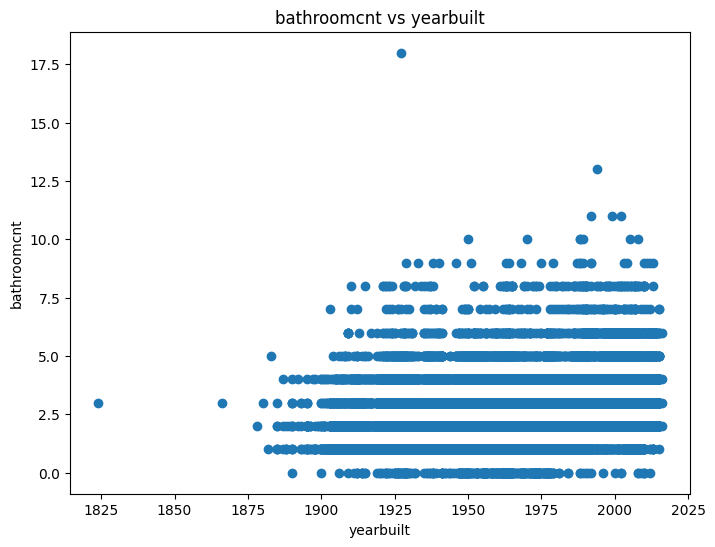

In [ ]:
# Plotting bathroomcnt v yearbuilt
x_col = 'yearbuilt'
y_col = 'bathroomcnt'
plt.figure(figsize=(8, 6))
plt.scatter(x[x_col], x[y_col])
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'{y_col} vs {x_col}')
plt.show()

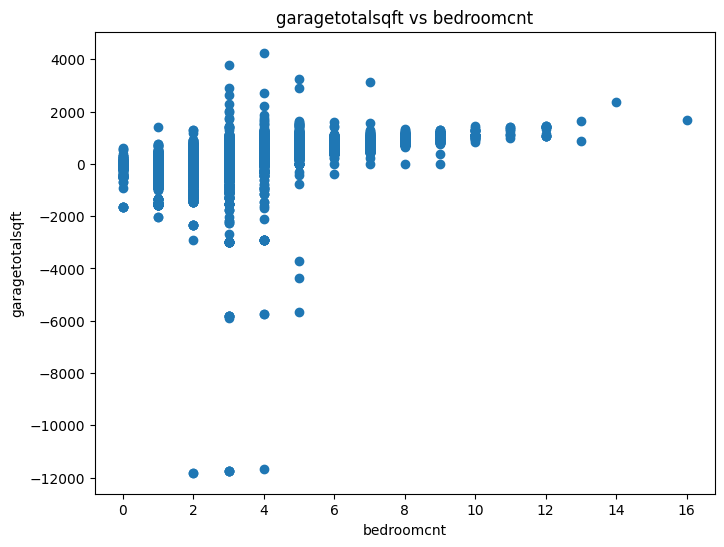

In [ ]:
# Plotting garagetotalsqft v bedroomcnt
x_col = 'bedroomcnt'
y_col = 'garagetotalsqft'
plt.figure(figsize=(8, 6))
plt.scatter(x[x_col], x[y_col])
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'{y_col} vs {x_col}')
plt.show()

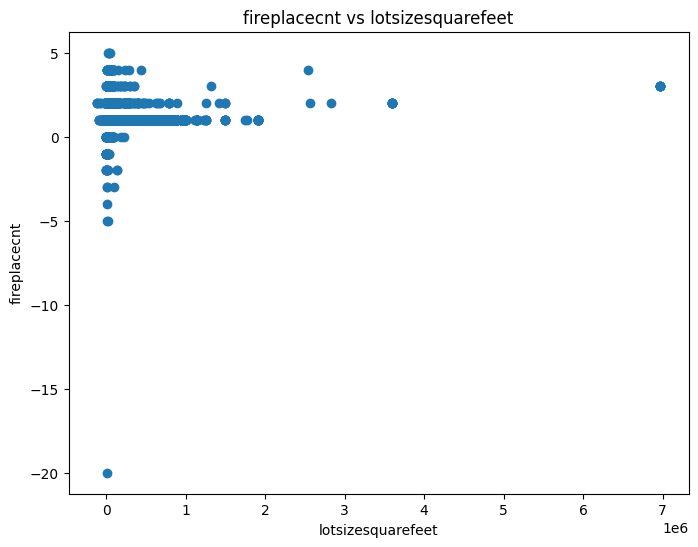

In [ ]:
# Plotting fireplacecnt v lotsizesquarefeet
x_col = 'lotsizesquarefeet'
y_col = 'fireplacecnt'
plt.figure(figsize=(8, 6))
plt.scatter(x[x_col], x[y_col])
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f'{y_col} vs {x_col}')
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


**bathroomcnt v yearbuilt:** Newer houses tend to have more bathrooms. This makes sense as more advanced plumbing allows for more dispersed bathrooms.

**garagetotalsquarefeet v bedroomcnt:** The more bedrooms there are, the larger the garage is. This correlation makes sense as larger houses can accomodate both of these ammenities. They also both have strong F-Statistics as well since these can both increase the value of a house.

**fireplacecnt v lotsizesquarefeet:** Similarly to the previous pattern, both of these features increase the value of a house. Also, more fireplace is correlated to larger square footage, which is more likely accommodated by a larger lot.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset.
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection).
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary.

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question.

Housekeeping: (Check heat map) (Peter)
- keep
- drop one of the sq feet columns to reduce redundancy
- drop latitude and longitude
- drop one of the bathroom count features to reduce redundancy

Feature engineering: (matt)
- bed and bathroom calculation
- logscale finished sqft
- polynomial feature from HOML

Part 1 (Nowrin)

In [ ]:
# Log Feature Function
def log_transform_feature(df, feature):
  '''
  This log transforms a feature to create a new feature in a DataFrame.

  Parameters:
  -----------
    df (np.DataFrame): The features.
    feature (str): The name of the feature to be transformed.

  Returns:
  --------
    df (np.DataFrame): The features.
  '''
  if feature not in df.columns:
    raise ValueError('Error: Features (bed and bath) not found.')
  else:
    new_name = 'log_' + feature
    df[new_name] = np.log1p(df[feature])
    df[new_name] = df[new_name].fillna(1)
    df[new_name] = df[new_name].replace([np.inf, -np.inf], 1)
    return df

# BedBath Calc Function
def calc_bedbath_feature(df, bedname, bathname):
  '''
  This calculates the number of beds over the number of baths to create a new feature in the DataFrame.

  Parameters:
  -----------
    df (np.DataFrame): The features.
    bedname (str): The name of one the features to be transformed.
    bathname (str): The name of one the features to be transformed.

  Returns:
  --------
    df (np.DataFrame): The features.
  '''
  if bedname not in df.columns and bathname not in df.columns:
    raise ValueError('Error: Features (bed and bath) not found.')
  else:
    new_name = 'calc_bedbath'
    df[new_name] = df[bedname] / df[bathname]
    df[new_name] = df[new_name].fillna(1)
    df[new_name] = df[new_name].replace([np.inf, -np.inf], 1)
    return df

# Polynomial Feature Function - Product
def calc_product_feature(df, feature1, feature2):
  '''
  This calculates the product of two to create a new feature in a DataFrame.

  Parameters:
  -----------
    df (np.DataFrame): The features.
    feature1 (str): The name of one the features to be transformed.
    feature2 (str): The name of one the features to be transformed.

  Returns:
  --------
    df (np.DataFrame): The features.
  '''
  if feature1 not in df.columns and feature2 not in df.columns:
    raise ValueError('Error: Features (bed and bath) not found.')
  else:
    new_name = 'prod_' + feature1 + '_' + feature2
    df[new_name] = df[feature1] * df[feature2]
    df[new_name] = df[new_name].fillna(1)
    return df


In [ ]:
# Engineering new features using defined functions
# First making a copy of the df
x_eng = x.copy()

# Log of sqft
x_eng = log_transform_feature(x_eng, 'garagetotalsqft')
x_eng = log_transform_feature(x_eng, 'lotsizesquarefeet')
x_eng = log_transform_feature(x_eng, 'calculatedfinishedsquarefeet')

# # Bedbath feature
x_eng = calc_bedbath_feature(x_eng, 'bathroomcnt', 'bedroomcnt')

# # Product feature
x_eng = calc_product_feature(x_eng, 'bathroomcnt', 'bedroomcnt')
x_eng = calc_product_feature(x_eng, 'fireplacecnt', 'garagecarcnt')

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


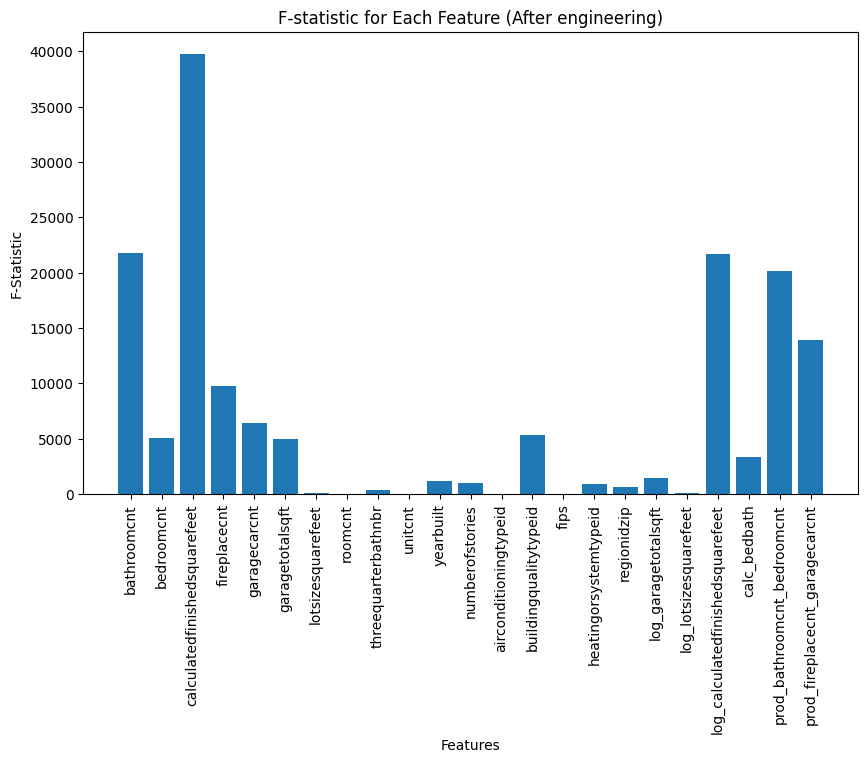

In [ ]:
# Computing the fstatistics
f2, p2 = f_regression(x_eng, y)
f_statistics2 = pd.DataFrame({'feature': x_eng.columns, 'f': f2})

# Ploting the F's
plt.figure(figsize=(10, 6))
plt.bar(f_statistics2['feature'], f_statistics2['f'])
plt.title('F-statistic for Each Feature (After engineering)')
plt.xlabel('Features')
plt.ylabel('F-Statistic')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed.


After engineering 5 extra features, there were mixed results. Some performed better in F-statistic than their non engineered counterparts, while some did not. We chose to log transform the three square footage variables since these could have extremes on the high end that likely wouldn't be linearly related to price. However, lotsizesquare feet showed little improvement when transformed, and garagetotalsqft actually got less informative. On the other hand, calculatedfinishedsquarefeet drastically improved in relevance to the target. Then we chose to run a custom calculation to determine the ratio of bedrooms to bathrooms, which was not a hugely informative metric, though more informative than the majority of variables in our existing features. That being said, it was less informative than both bathroomcnt and bedroomcnt, so it is likely not a good choice. Finally, we found the products of features as well - it was very succesful in F-Statistic terms. Both bathroomcnt times bedroomcnt and fireplacecnt times garagecarcnt were fairly informative to the target. Bathroomcnt on its own had a higher F-Statistic, but bedroomcnt did not when compared to the combination. Fireplacecnt and garagecarcnt were significantly less informative than the product of the two, so this is a good feature to incorporate into the model. There are more possible features to engineer as well, but these did add potential improvements to a future model.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

